In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import os
import re

In [74]:
authors_short_dict = {"MWS": "Mary Shelley", "HPL": "H. P. Lovecraft", "EAP": "Edgar Allan Poe"}
df = pd.DataFrame(pd.read_json("preprocessing_output/preprocessed_test_W.json").author)
df["author_short"] = df.author
df.author = df.author.apply(lambda x: authors_short_dict[x])
for filename in os.listdir("results_output/"):
    fileparts = filename.split("_")
    method = fileparts[1]
    if "template" in method:
        continue
    preprocessing = ".".join(fileparts[2].split(".")[:-1])
    df[f"{method} with {preprocessing}"] = pd.read_json(f"results_output/results_{method}_{preprocessing}.json")
# df


In [75]:
total_table = pd.DataFrame()
for (name, func) in metrics:
    for method in ["bayes", "lda"]:
        authors = defaultdict(lambda: [])
        for author in ["EAP", "HPL", "MWS"]:
            method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})")]
            author_df = pd.DataFrame({"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                    lambda x: [1 if author == i else 0 for i in x])], axis=1) 
            author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
            authors[author] = author_df.iloc[:, 2:].apply(lambda x: func(author_df["author_short"], x))
        authors = pd.DataFrame(authors)
        total_table = pd.concat([total_table, authors], axis=1)
pd.set_option('display.max_columns', None)
total_table.columns = pd.MultiIndex.from_product([map(lambda x: x[0], metrics), ["bayes", "lda"], ["EAP", "HPL", "MWS"]])
total_table

Accuracy                                                    \
             bayes                           lda                       
               EAP       HPL       MWS       EAP       HPL       MWS   
W         0.872829  0.913943  0.896578  0.774515  0.819969  0.828396   
CSPH1e-4  0.711951  0.768641  0.756384  0.655516  0.729826  0.677988   
WSP       0.876915  0.914198  0.905516  0.764300  0.815373  0.816650   
CSPH1e-5  0.746425  0.803371  0.780644  0.690245  0.735189  0.731869   
C         0.724974  0.783963  0.766343  0.640705  0.640449  0.719867   
WSPH1e-4  0.853933  0.668539  0.654750  0.694331  0.745659  0.717314   
WSPH1e-6  0.876915  0.914198  0.905516  0.792646  0.802860  0.825332   
CSPH5e-5  0.722676  0.781920  0.775281  0.676200  0.715526  0.716547   
CSPH1e-6  0.750511  0.808733  0.780388  0.666241  0.710674  0.736977   
WSPH5e-4  0.636619  0.767365  0.756895  0.602145  0.640449  0.670072   
CSPH5e-4  0.629724  0.717314  0.699949  0.598825  0.663432  0.682584   
CSP       0.750511  0.808733  0.780388  0.667518  0.735700  0.739785   
WSPH1e-5  0.853422  0.894791  0.890705  0.751532  0.770684  0.775026   
WSPH5e-5  0.806180  0.862870  0.861593  0.723698  0.733912  0.788049   
WL        0.872829  0.913943  0.896578  0.772983  0.801583  0.815628   
WPH1e-4   0.766854  0.836057  0.830695       NaN       NaN       NaN   

         Precision                                                    \
             bayes                           lda                       
               EAP       HPL       MWS       EAP       HPL       MWS   
W         0.866795  0.900087  0.877484  0.768309  0.784228  0.859157   
CSPH1e-4  0.702084  0.719575  0.716444  0.641741  0.666387  0.634397   
WSP       0.869472  0.904697  0.890387  0.753808  0.776488  0.791432   
CSPH1e-5  0.734682  0.763010  0.745306  0.677823  0.684203  0.685042   
C         0.713205  0.738852  0.728337  0.631995  0.632692  0.736136   
WSPH1e-4  0.857707  0.585982  0.626786  0.681309  0.689042  0.675629   
WSPH1e-6  0.869472  0.904697  0.890387  0.783052  0.766929  0.812834   
CSPH5e-5  0.711830  0.736419  0.738943  0.661134  0.659542  0.668395   
CSPH1e-6  0.738769  0.770000  0.745463  0.662951  0.671771  0.717543   
WSPH5e-4  0.681102  0.740516  0.723988  0.591880  0.557582  0.609618   
CSPH5e-4  0.634578  0.645720  0.644975  0.600584  0.593317  0.610430   
CSP       0.738769  0.770000  0.745463  0.667356  0.686868  0.706917   
WSPH1e-5  0.845480  0.881756  0.876134  0.741315  0.732999  0.739671   
WSPH5e-5  0.800401  0.846475  0.844871  0.710379  0.696898  0.763458   
WL        0.866795  0.900087  0.877484  0.764089  0.771302  0.853722   
WPH1e-4   0.765193  0.814249  0.809952       NaN       NaN       NaN   

            Recall                                                    \
             bayes                           lda                       
               EAP       HPL       MWS       EAP       HPL       MWS   
W         0.866961  0.889737  0.885079  0.779493  0.816929  0.740538   
CSPH1e-4  0.708490  0.704557  0.711083  0.644243  0.643563  0.642256   
WSP       0.876453  0.884537  0.890041  0.758824  0.782420  0.771347   
CSPH1e-5  0.736368  0.755490  0.747552  0.681399  0.693475  0.665803   
C         0.716969  0.733320  0.723866  0.637009  0.660099  0.567271   
WSPH1e-4  0.834141  0.577708  0.643021  0.683977  0.670381  0.683065   
WSPH1e-6  0.876453  0.884537  0.890041  0.781872  0.800740  0.765508   
CSPH5e-5  0.717226  0.725983  0.733252  0.661423  0.664719  0.662603   
CSPH1e-6  0.738606  0.760048  0.752895  0.670434  0.696396  0.616004   
WSPH5e-4  0.674440  0.646257  0.673195  0.595106  0.555041  0.603095   
CSPH5e-4  0.640643  0.615759  0.633042  0.605287  0.593317  0.581912   
CSP       0.738606  0.760048  0.752895  0.675227  0.699986  0.635521   
WSPH1e-5  0.855595  0.858780  0.867531  0.730495  0.763399  0.722008   
WSPH5e-5  0.813101  0.811626  0.827528  0.707528  0.725628  0.719331   
WL        0.866961  0.889737  0.885079  0.772562

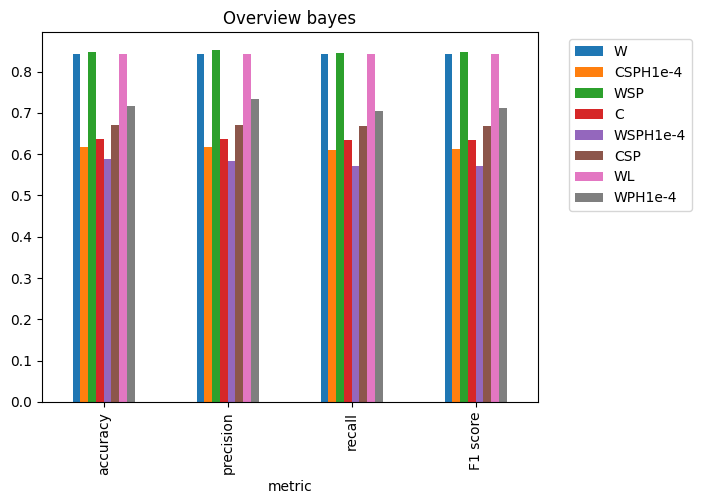

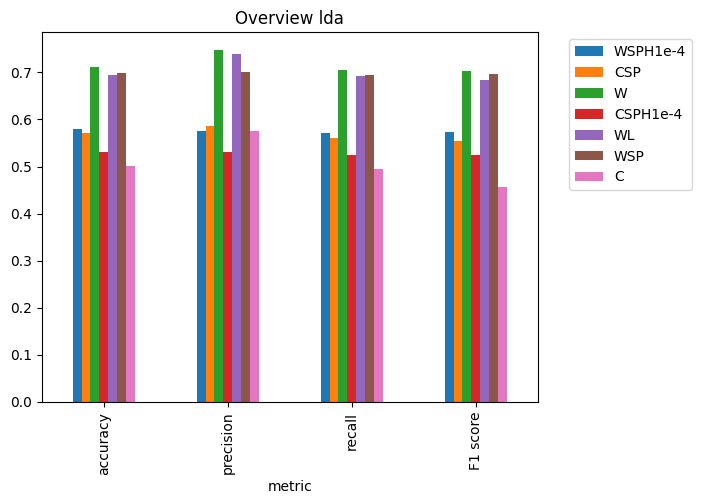

In [76]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
    method_df = method_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
    score_df = method_df.iloc[: , 2:].apply(lambda x: [accuracy_score(x, method_df["author_short"]), precision_score(method_df["author_short"], x, average="macro"), recall_score(method_df["author_short"], x, average="macro"), f1_score(method_df["author_short"], x, average="macro")])
    score_df["metric"] = ["accuracy", "precision", "recall", "F1 score"]
    score_df.plot.bar("metric", title=f"Overview {method}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

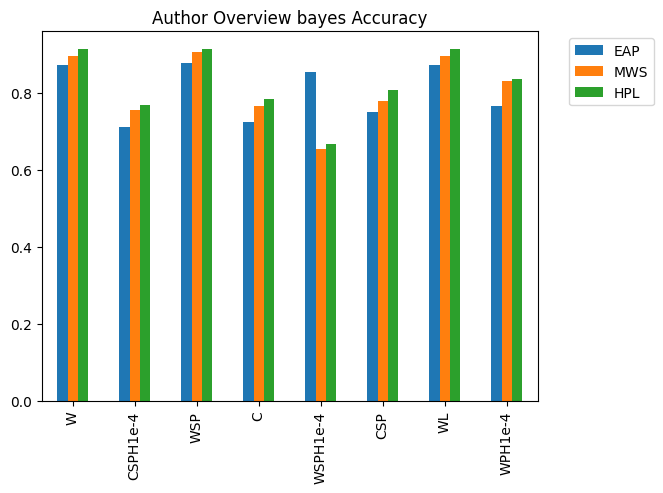

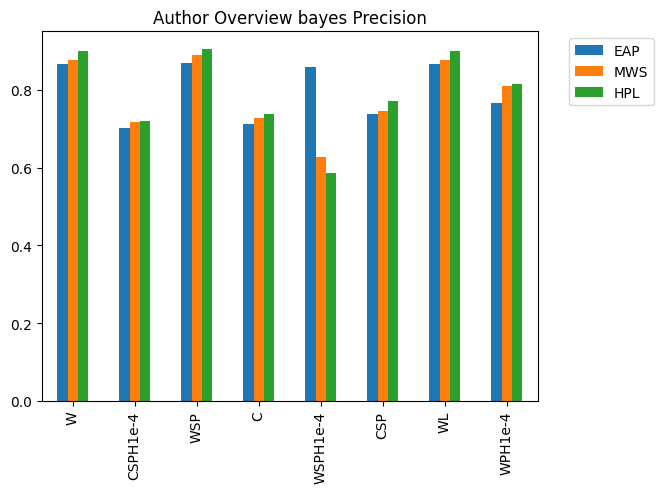

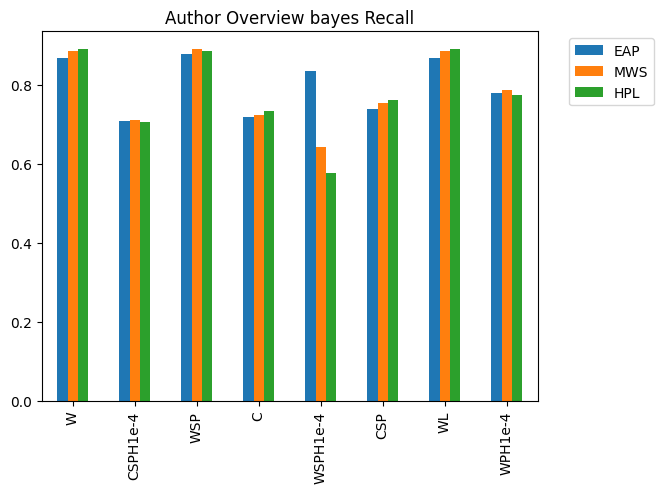

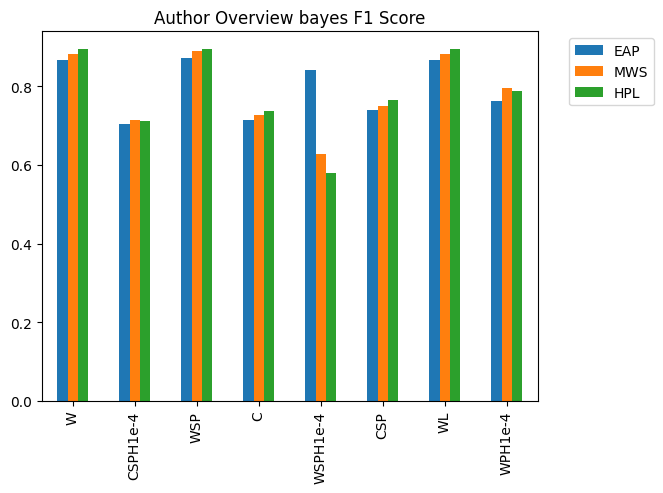

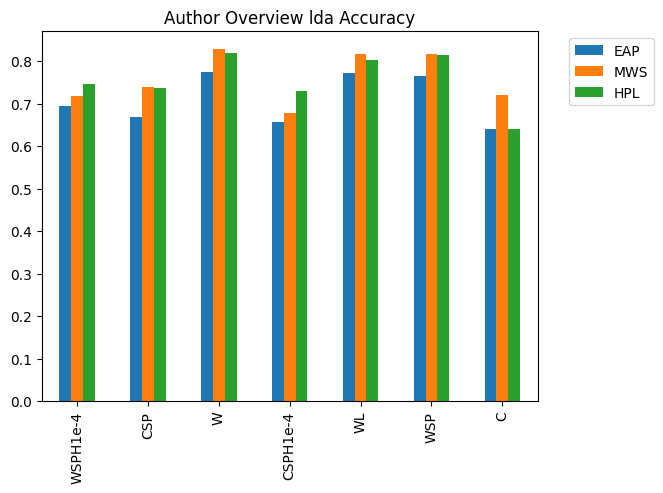

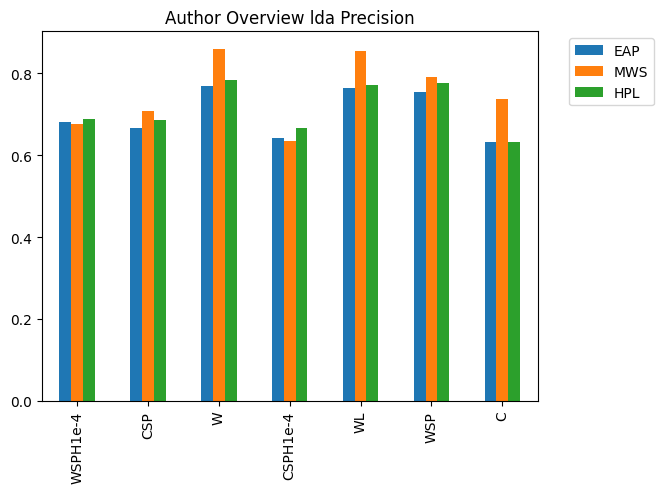

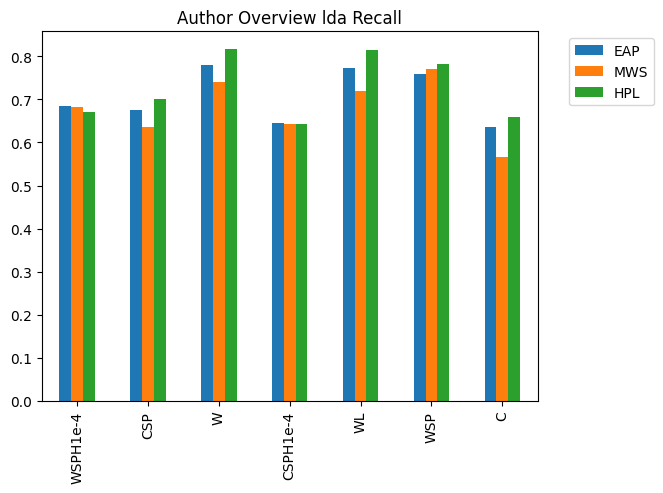

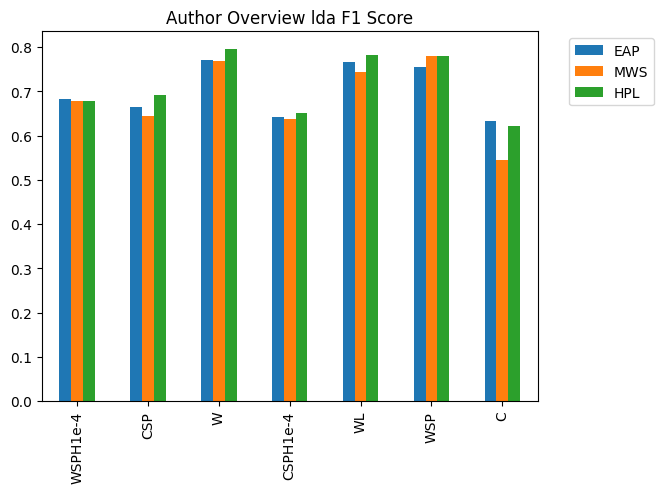

In [77]:
from collections import defaultdict

metrics = [("Accuracy", accuracy_score), ("Precision", lambda x, y: precision_score(x, y, average="macro")), ("Recall",
                                                                                                              lambda x, y: recall_score(x, y, average="macro")), ("F1 Score", lambda x, y: f1_score(x, y, average="macro"))]
for method in ["bayes", "lda"]:
    for (name, func) in metrics:
        score_df = {}
        method_df = df.loc[:, df.columns.str.contains(
            f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
        for author in ["EAP", "MWS", "HPL"]:
            author_df = pd.DataFrame(
                {"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                lambda x: [1 if author == i else 0 for i in x])], axis=1)
            author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
            score_df[author] = author_df.iloc[:, 2:].apply(
                lambda x: func(author_df["author_short"], x))
        score_df = pd.DataFrame(score_df)
        score_df.plot.bar(title=f"Author Overview {method} {name}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


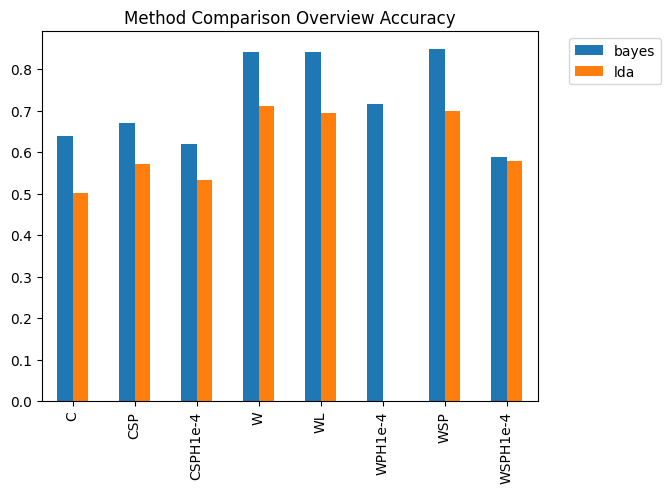

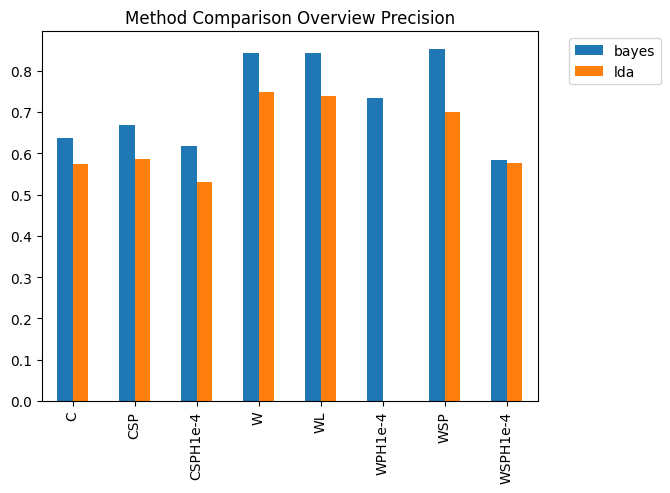

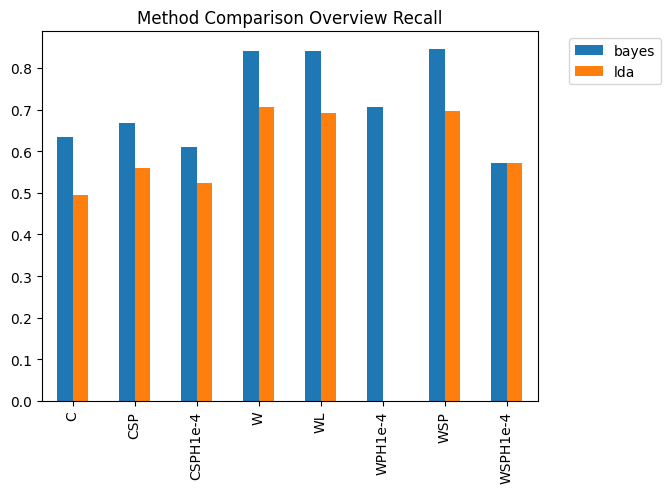

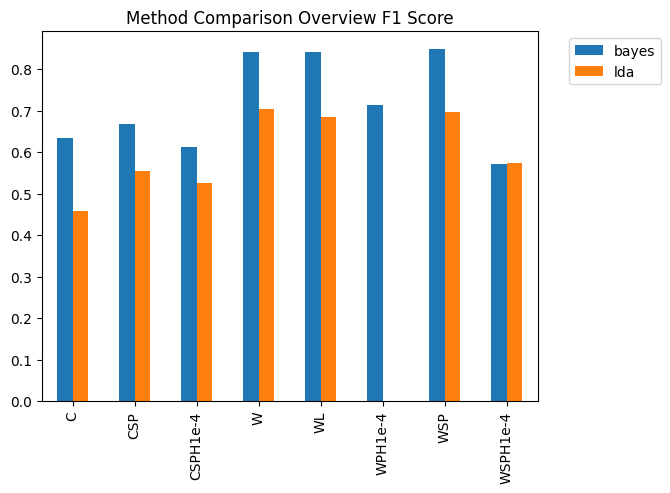

In [78]:
for (name, func) in metrics:
    preprocess_df = {}
    for method in ["bayes", "lda"]:
        score_df = df.loc[:, df.columns.str.contains(f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
        score_df = score_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
        score_df = score_df.iloc[:, 2:].apply(lambda x: func(score_df["author_short"], x))
        preprocess_df[method] = score_df
    preprocess_df = pd.DataFrame(preprocess_df)
    preprocess_df.plot.bar(title=f"Method Comparison Overview {name}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

/tmp/ipykernel_21446/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
/tmp/ipykernel_21446/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
/tmp/ipykernel_21446/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
/tmp/ipykernel_21446/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.e

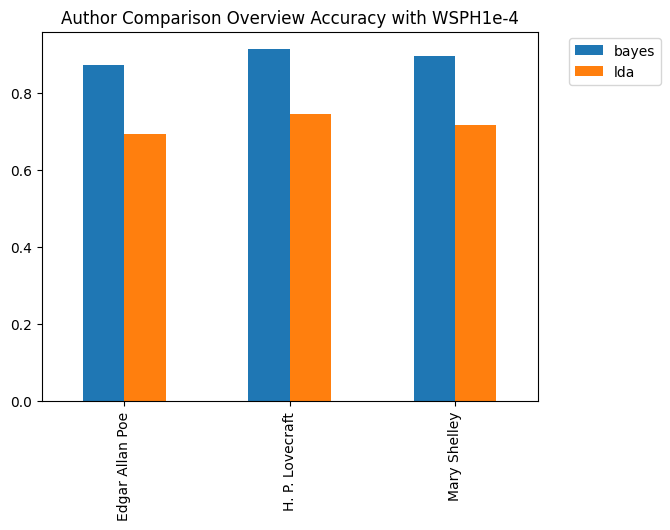

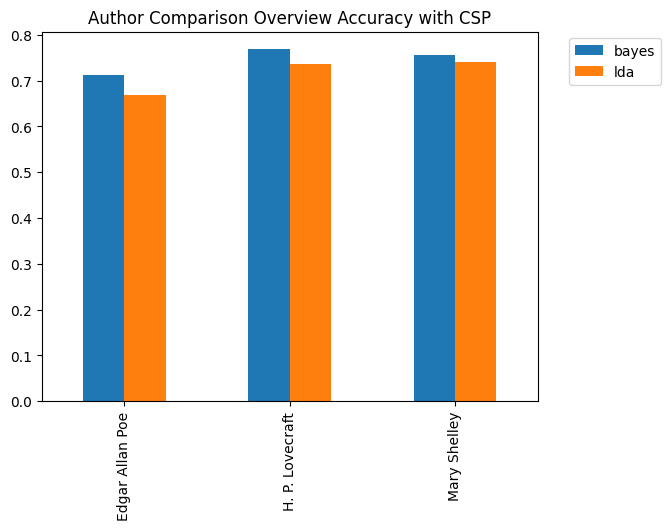

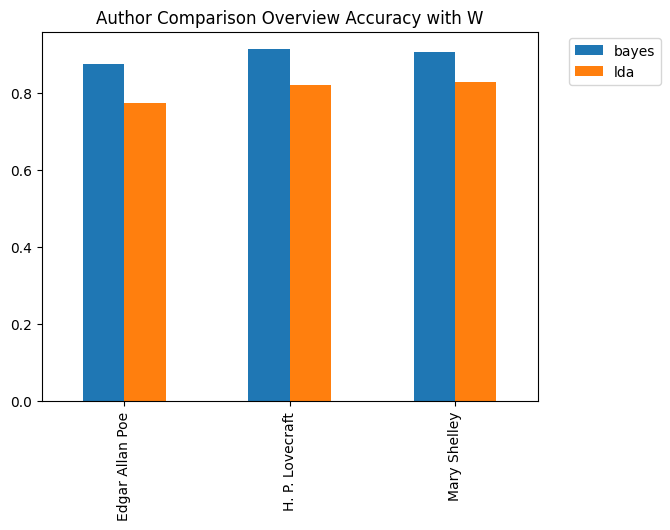

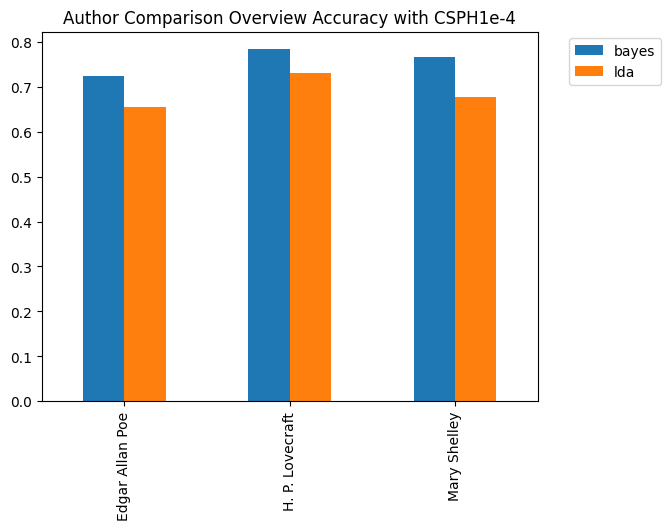

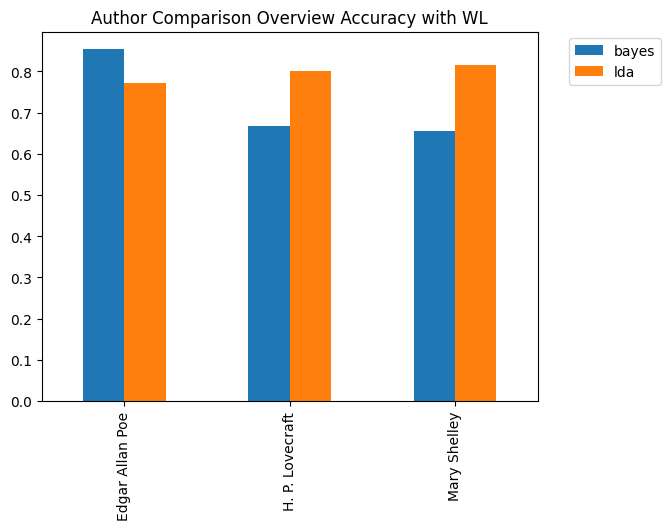

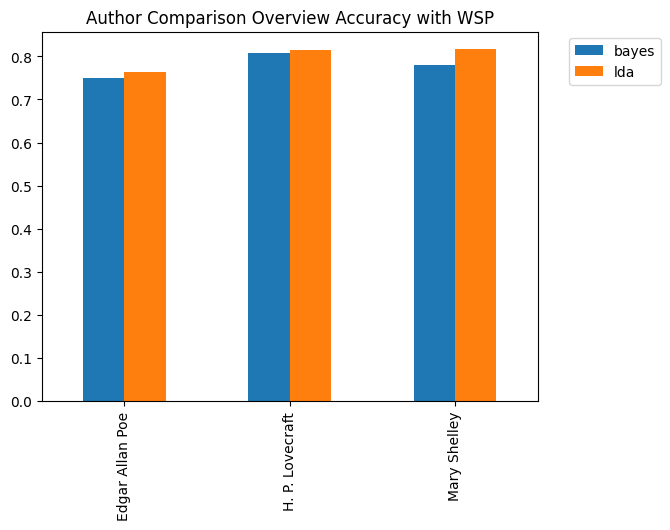

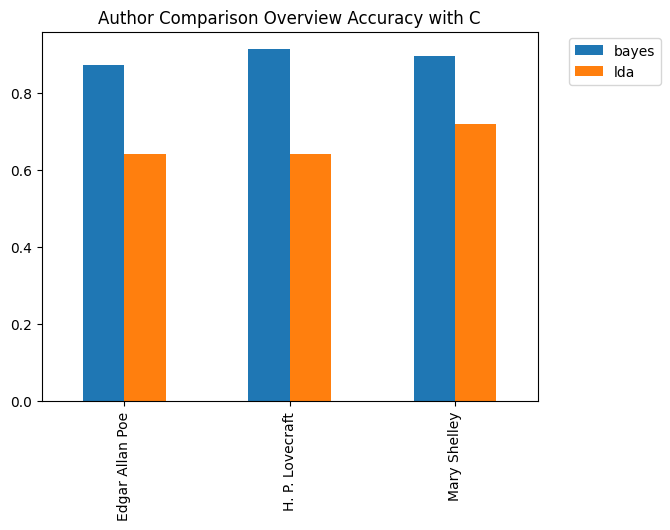

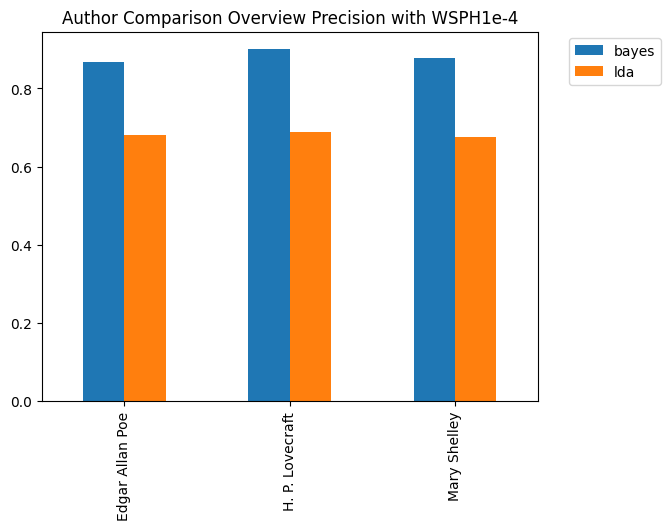

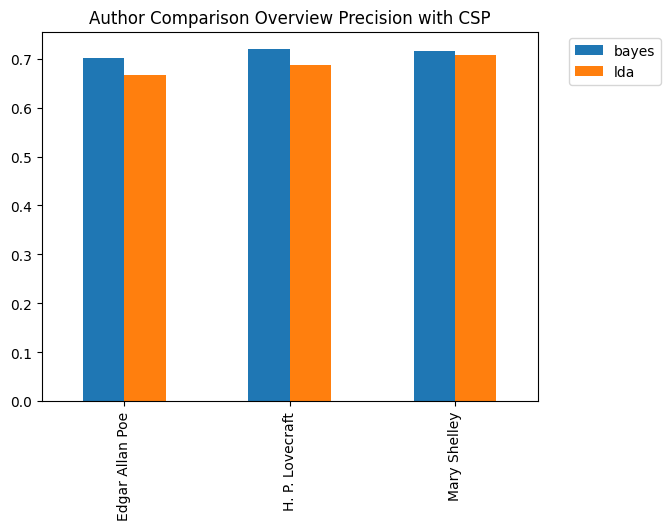

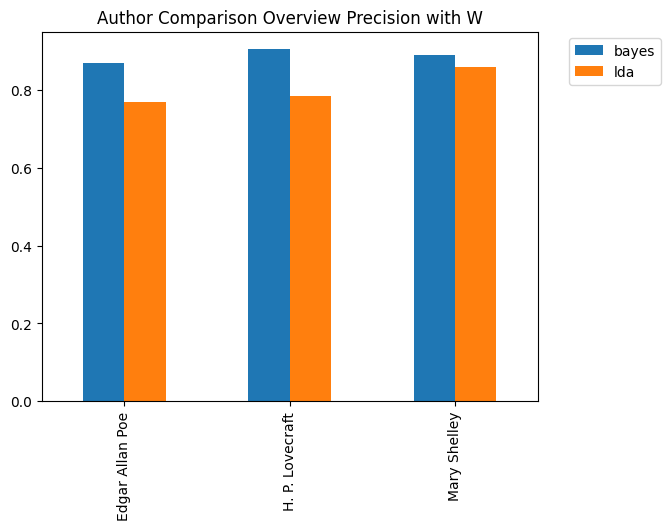

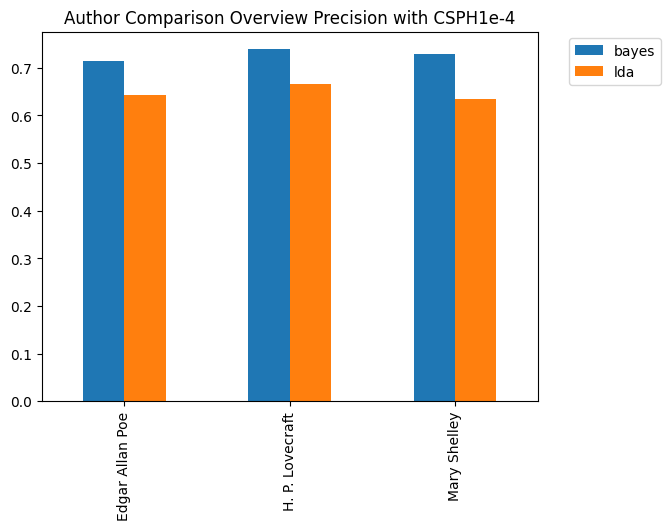

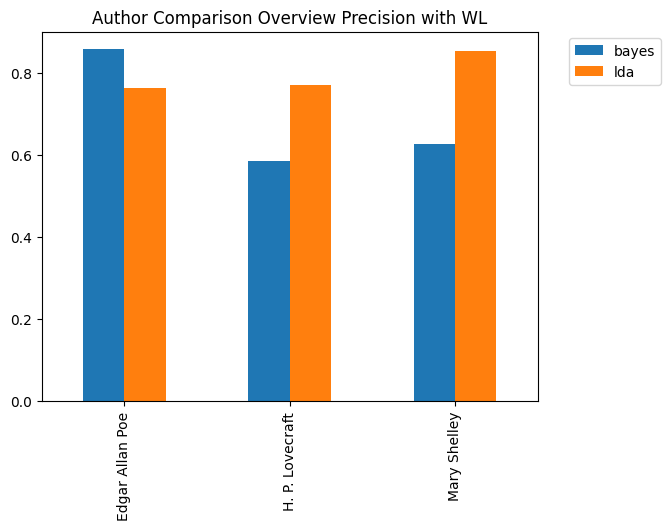

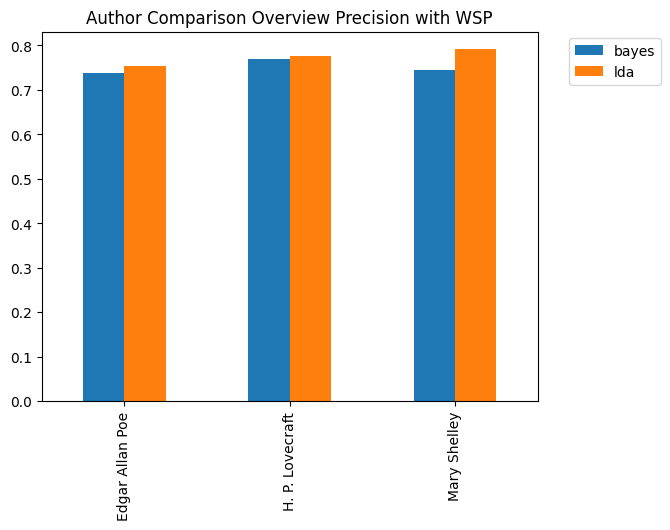

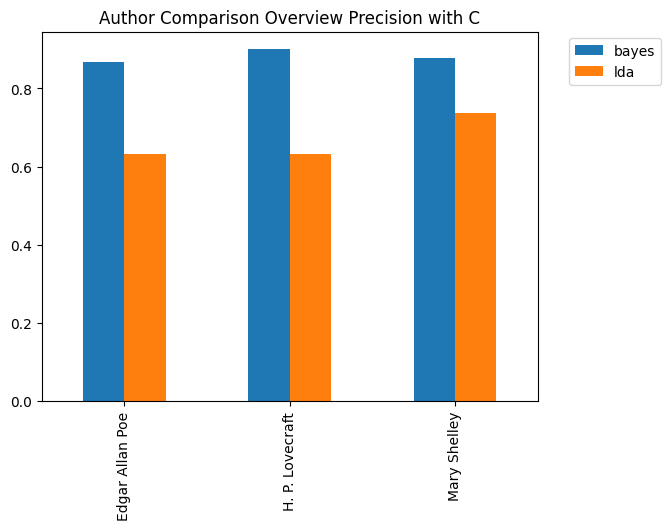

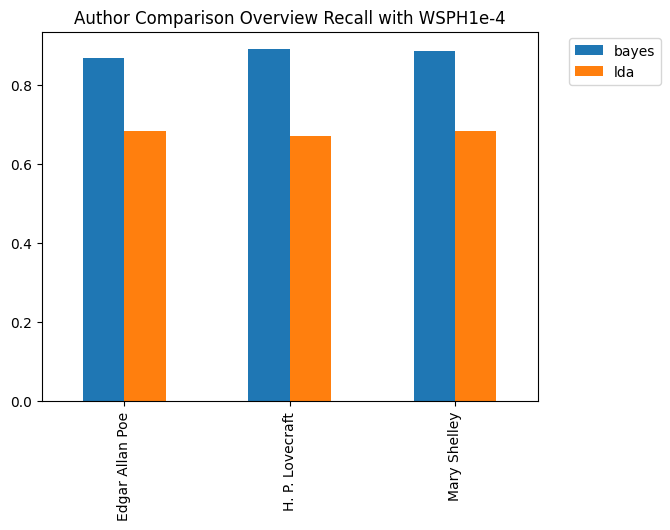

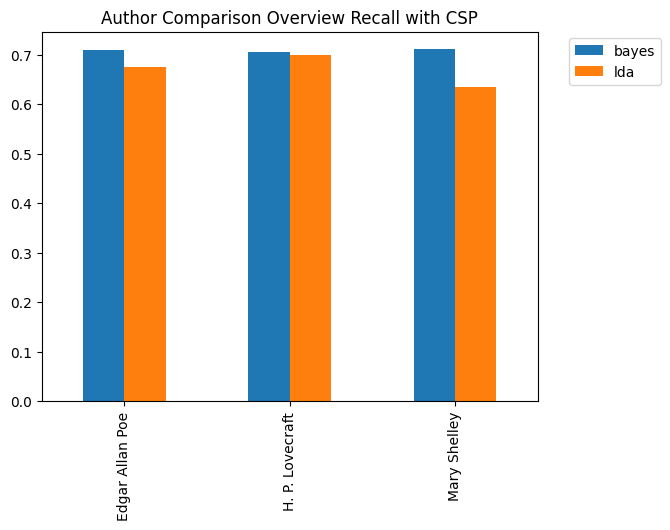

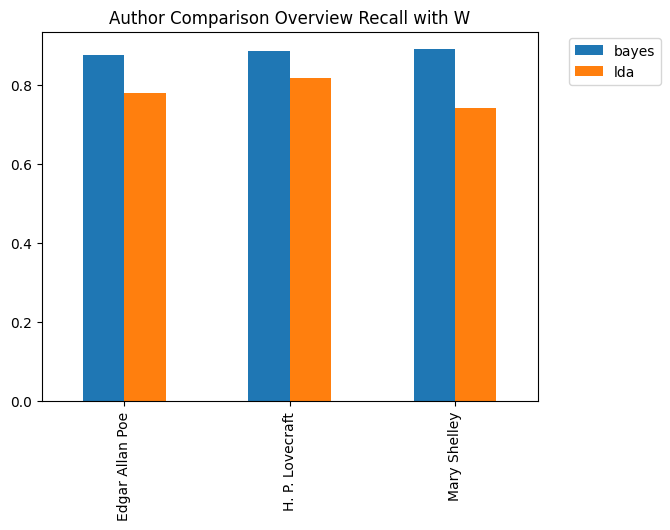

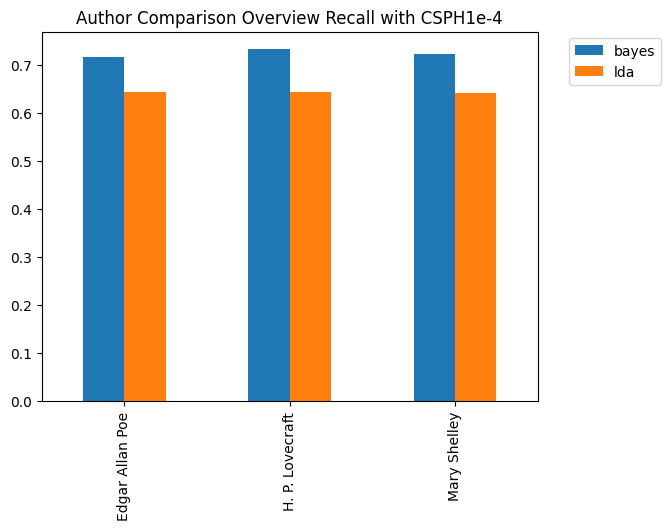

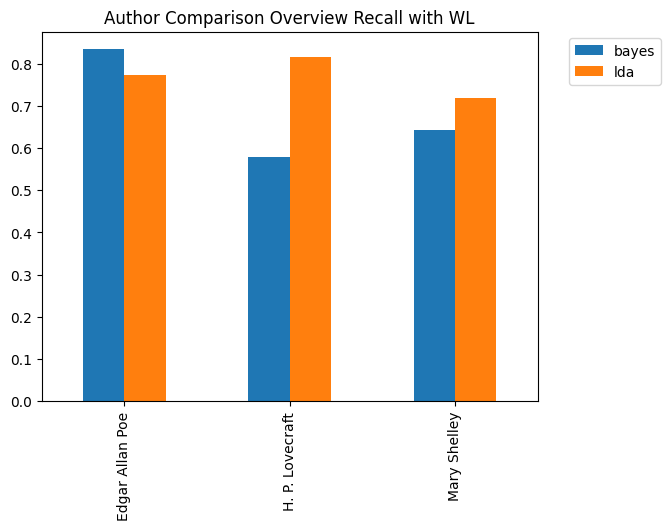

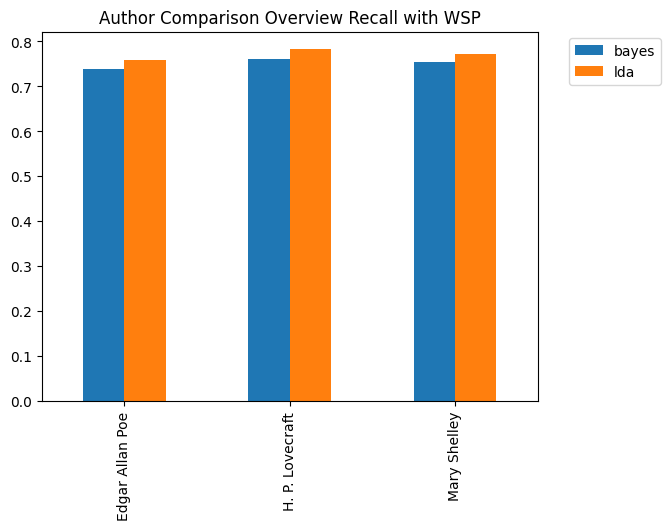

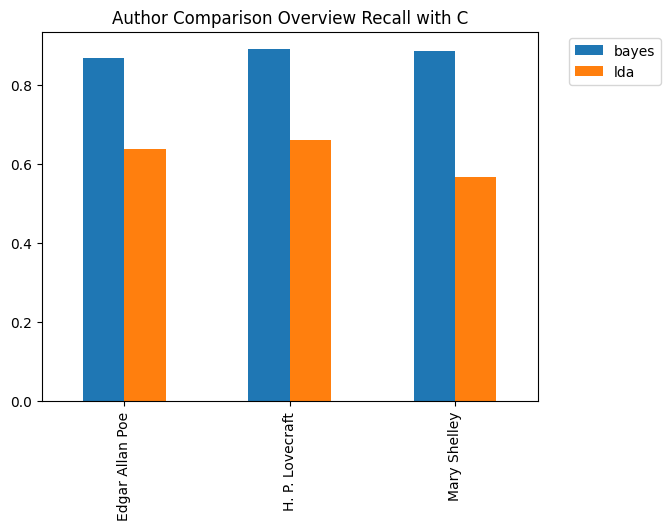

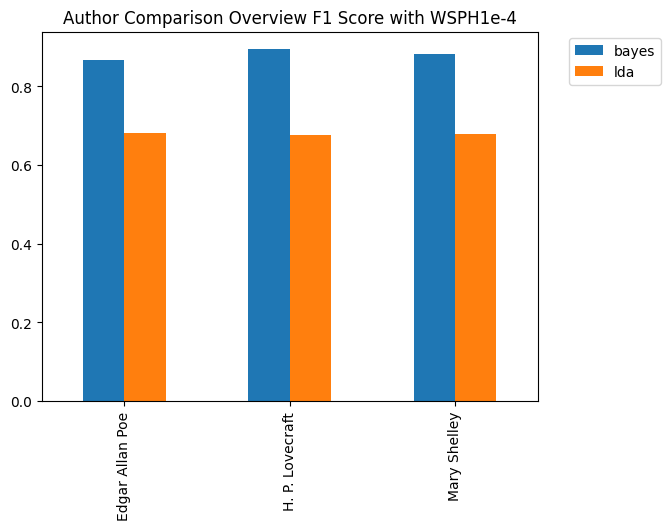

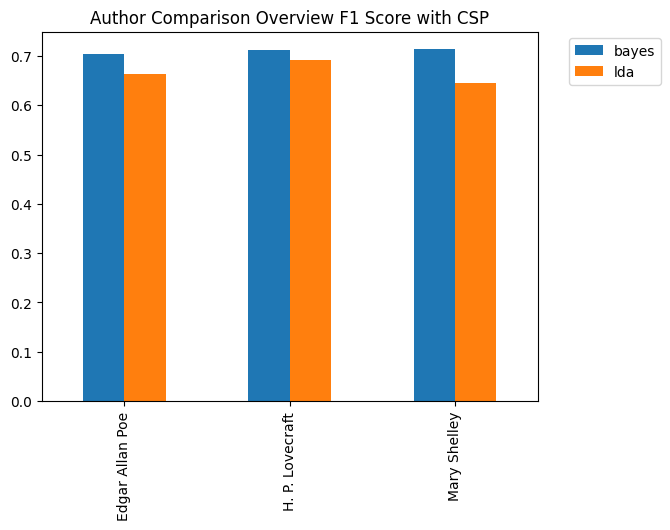

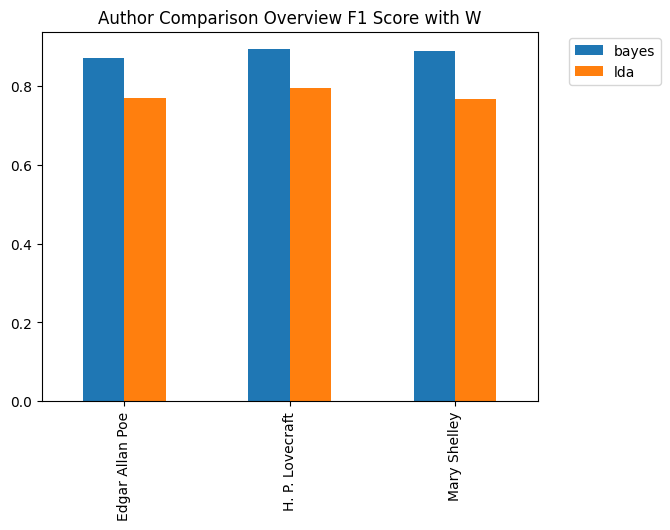

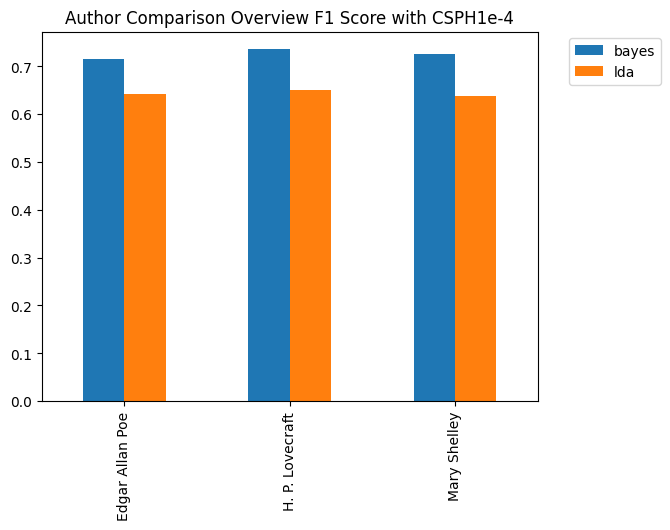

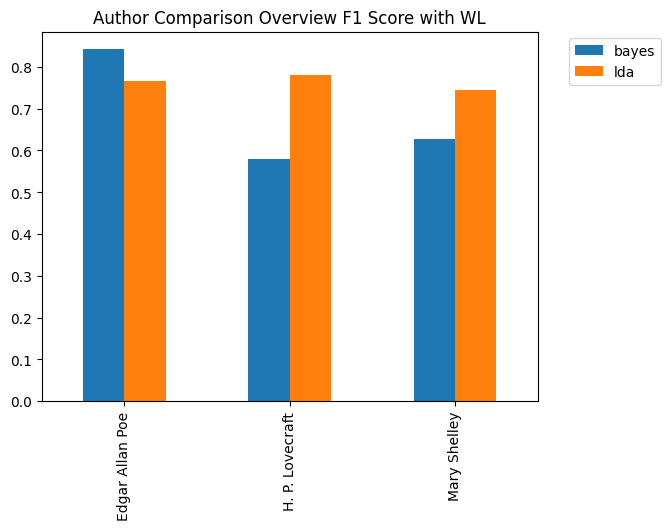

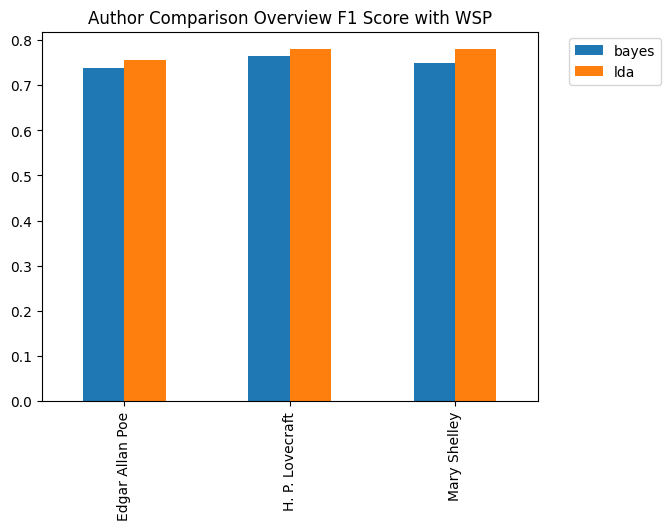

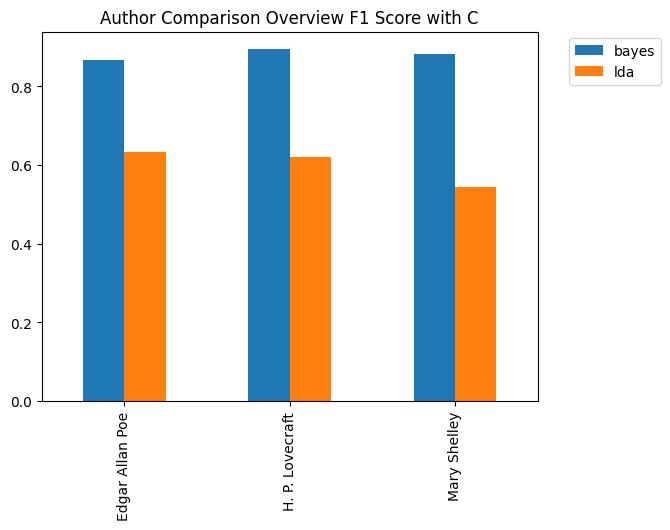

In [79]:
for (name, func) in metrics:
    method_df = df.loc[:, df.columns.str.contains(f"^[^56]*$")]
    for preprocessing in range(2,int((len(method_df.columns)) / 2 + 1)):
        authors = defaultdict(lambda: [])
        preprocess_name = ""
        for author in ["EAP", "HPL", "MWS"]:
            author_df = pd.DataFrame(
                            {"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                lambda x: [1 if author == i else 0 for i in x])], axis=1)
            for method in ["bayes", "lda"]:
                process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
                preprocess_name = re.sub(".*\s(\S+)$", r"\1", process_df.columns[preprocessing])
                authors[author].append(func(process_df["author_short"],process_df.iloc[:, preprocessing]))
        authors = pd.DataFrame(authors)
        authors = authors.rename(columns=lambda x: authors_short_dict[x])
        authors["method"] = ["bayes", "lda"]
        authors = authors.pivot_table(columns ="method")
        authors.plot.bar(title=f"Author Comparison Overview {name} with {preprocess_name}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

/tmp/ipykernel_21446/579560021.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  method_df = df.loc[:, df.columns.str.contains(f"(author|{method})")]
/tmp/ipykernel_21446/579560021.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  method_df = df.loc[:, df.columns.str.contains(f"(author|{method})")]
/home/tristan/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


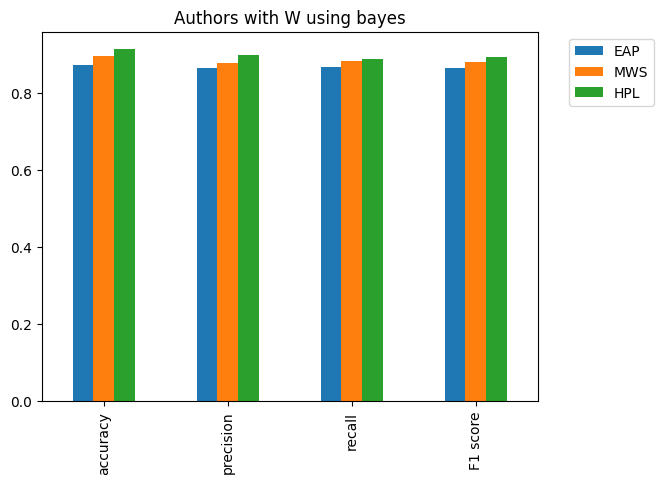

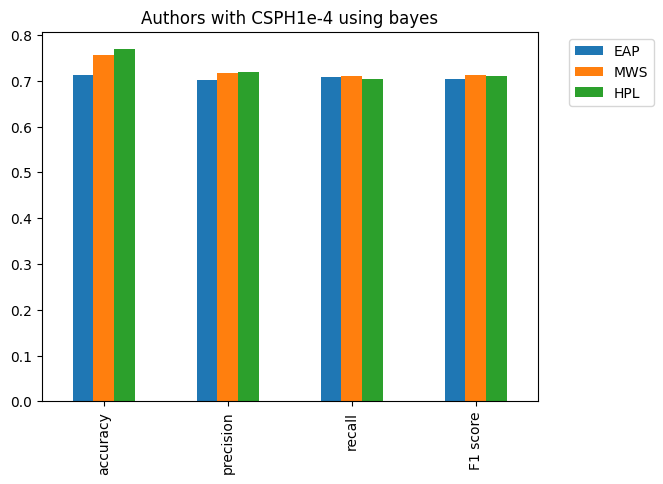

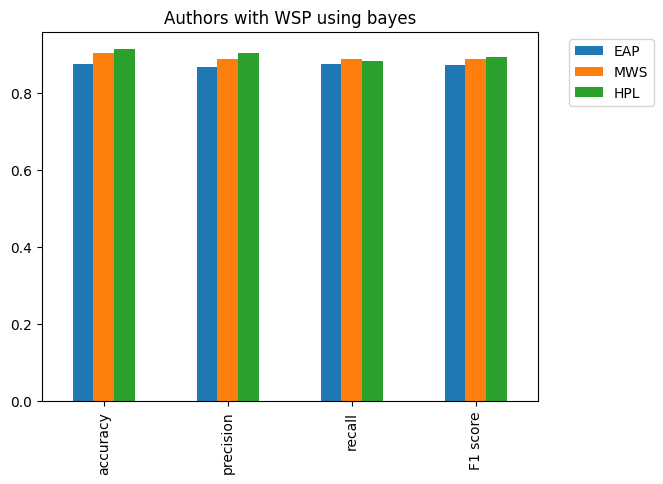

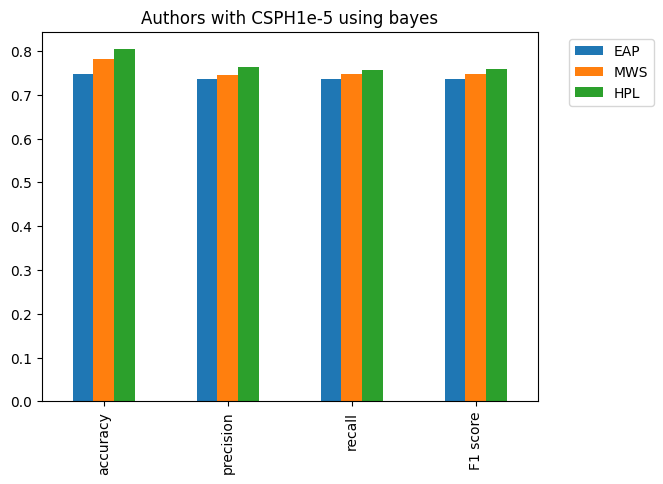

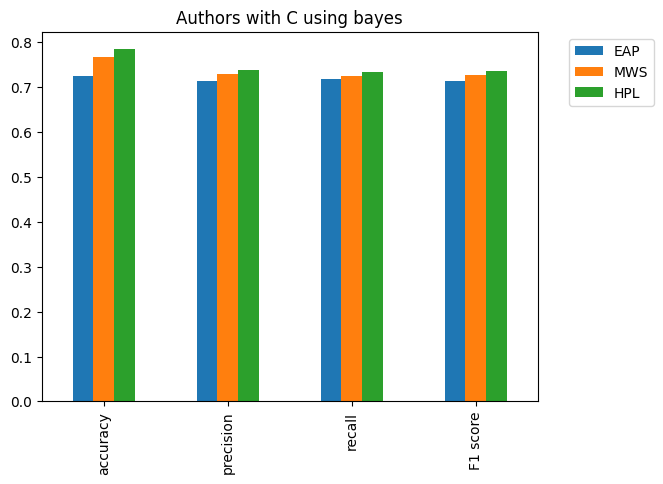

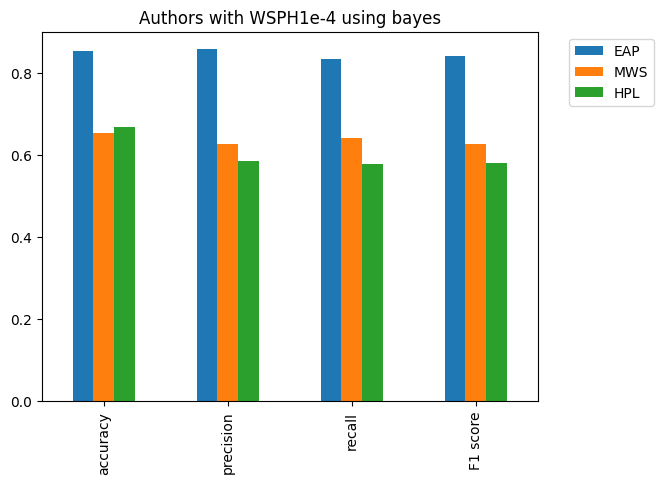

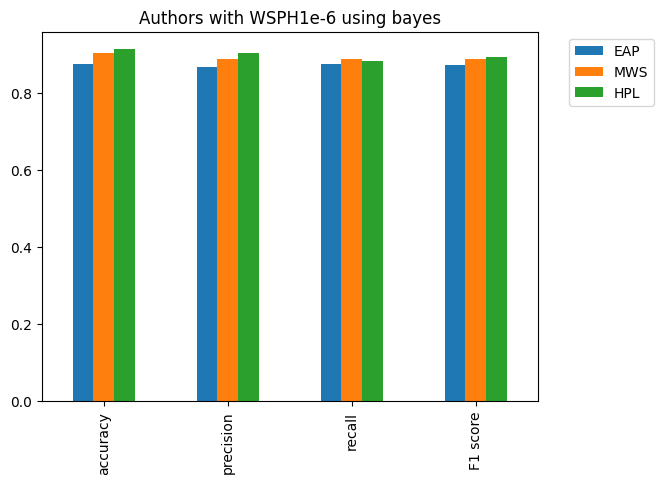

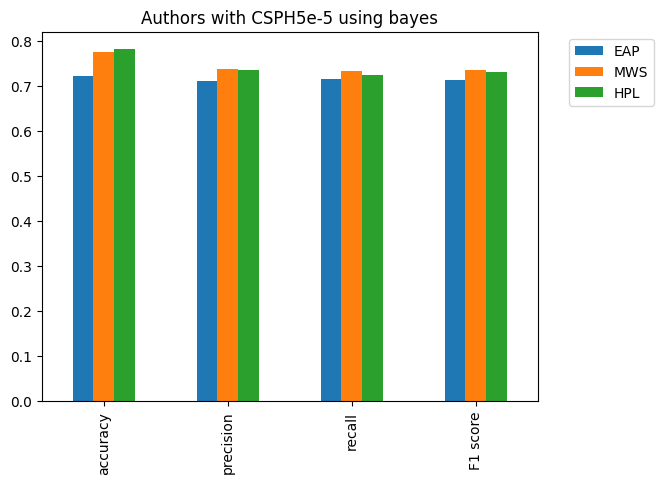

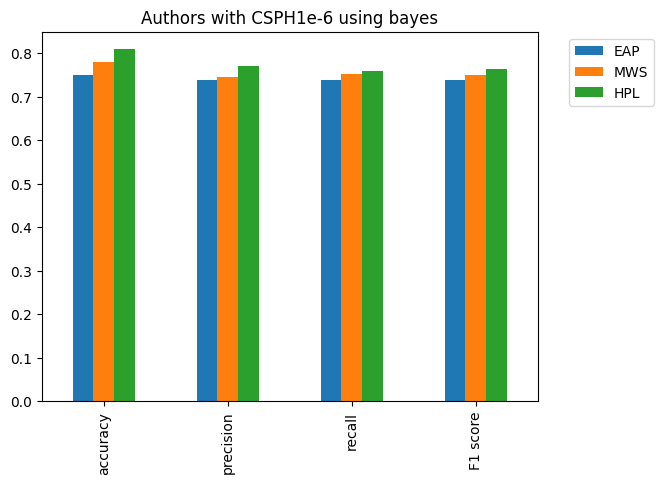

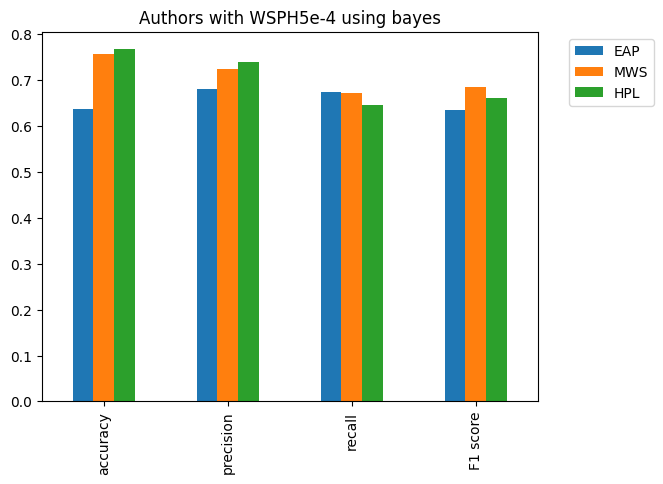

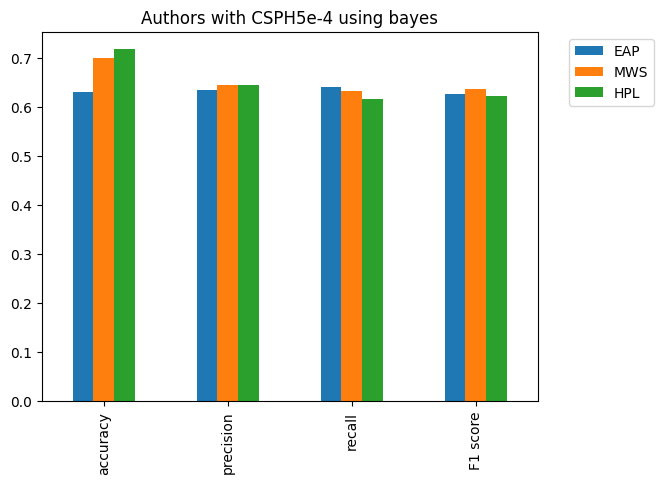

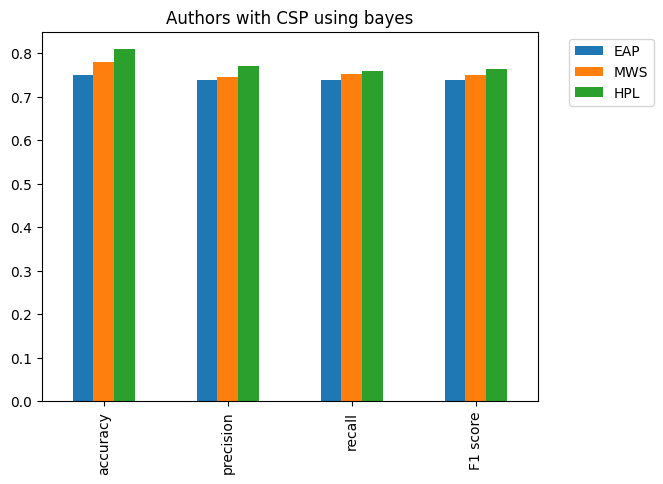

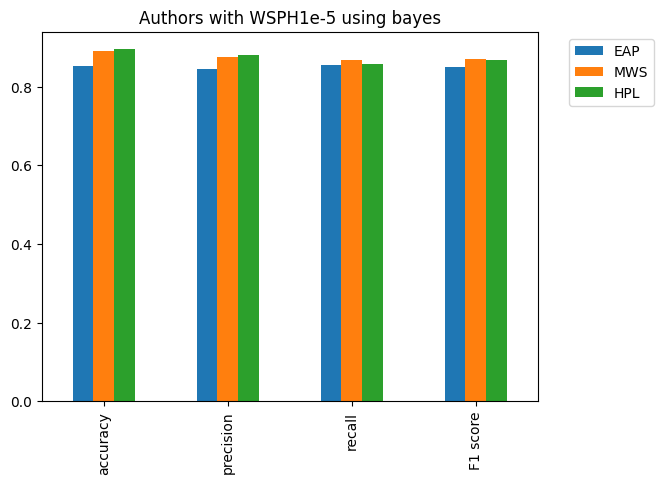

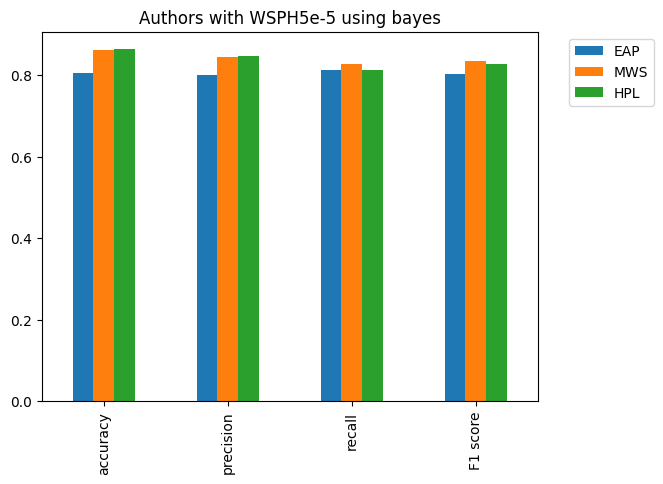

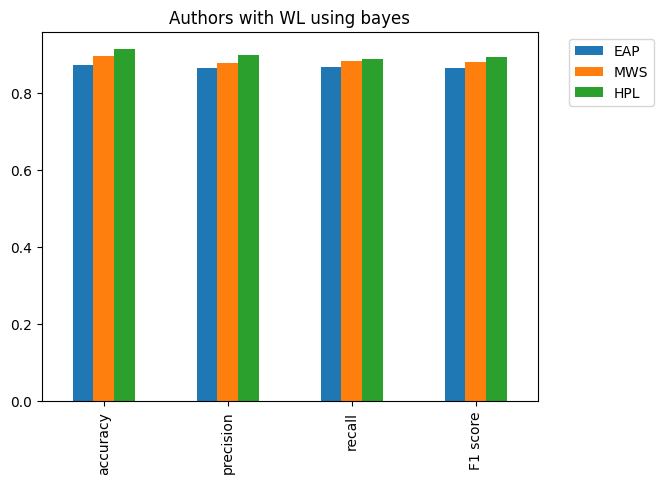

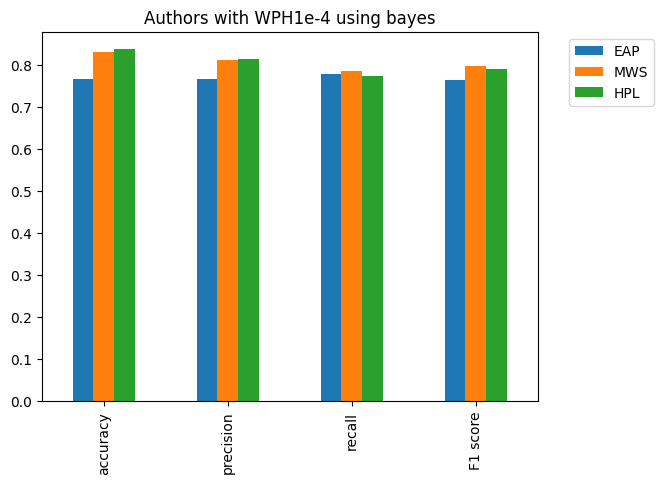

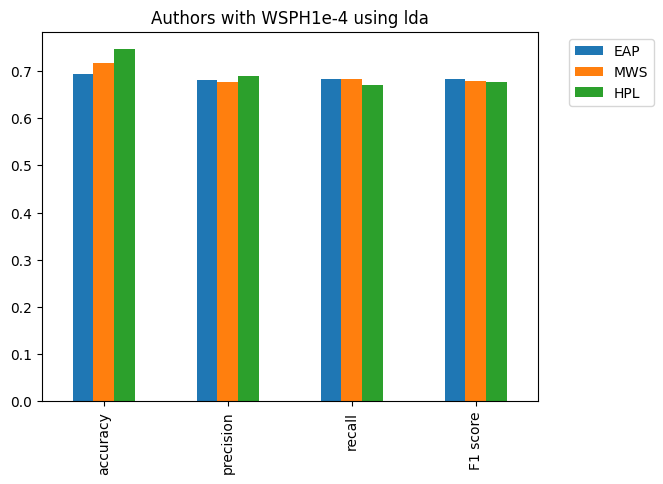

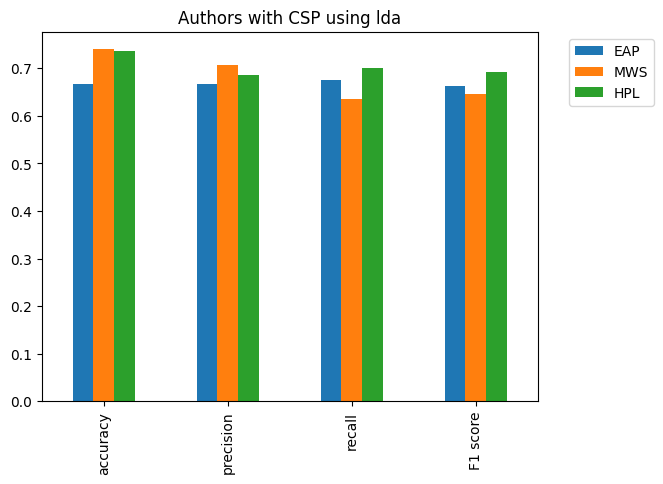

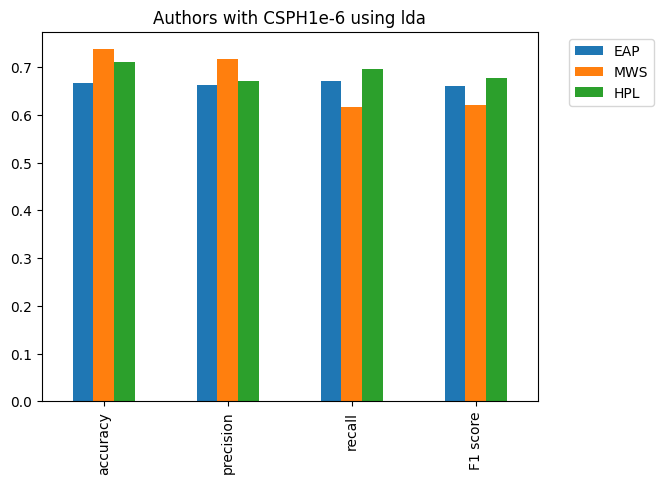

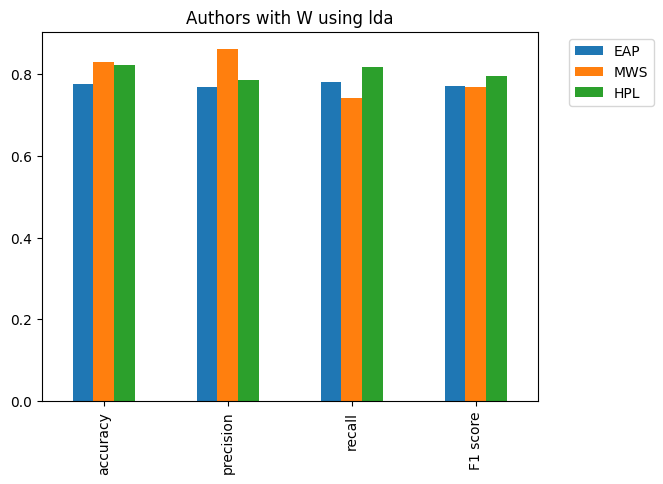

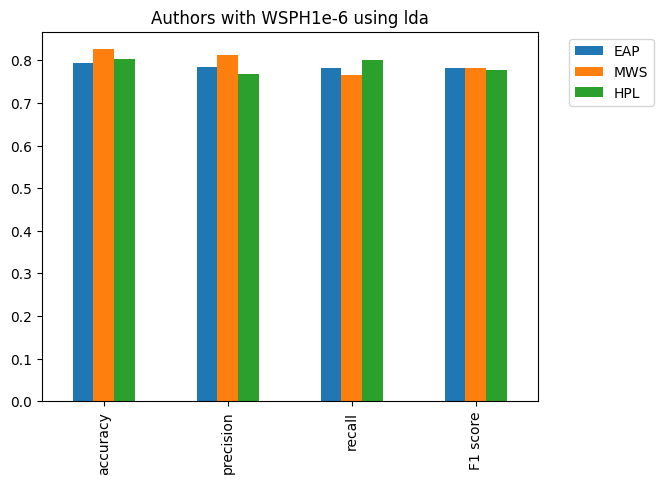

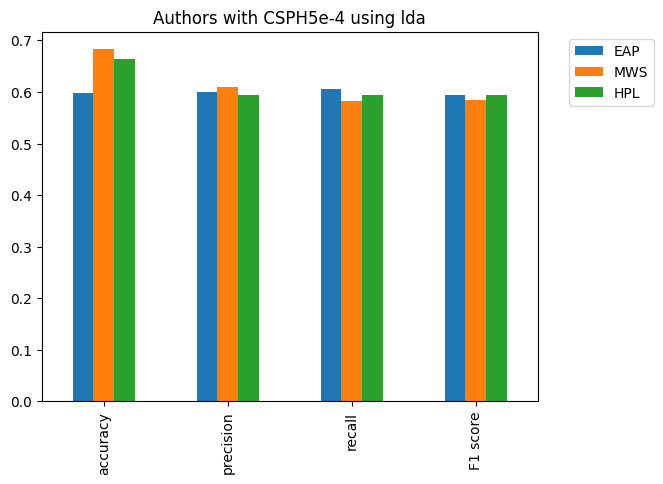

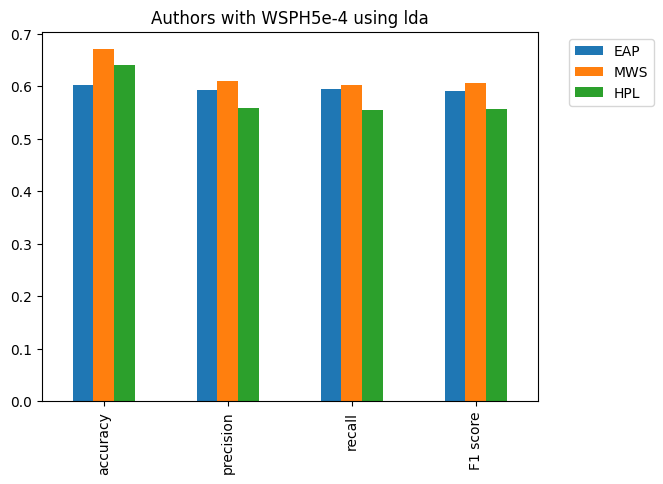

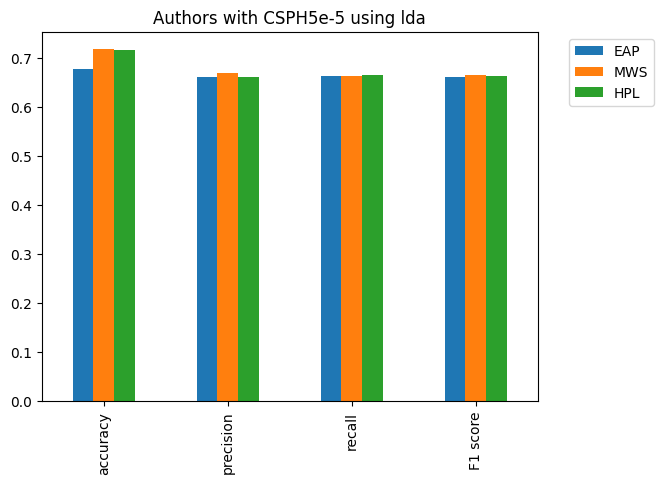

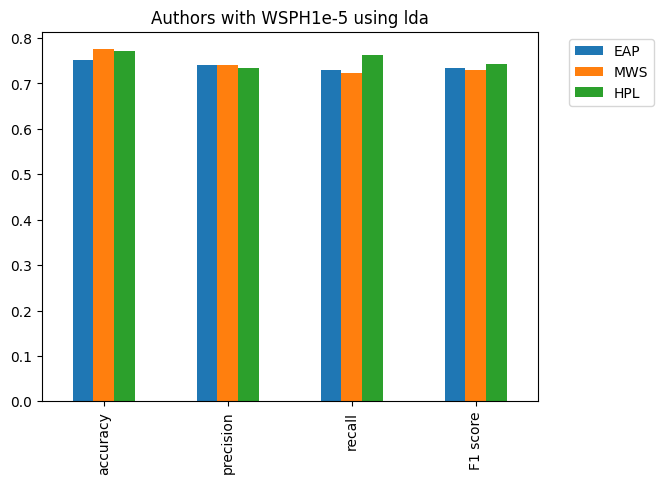

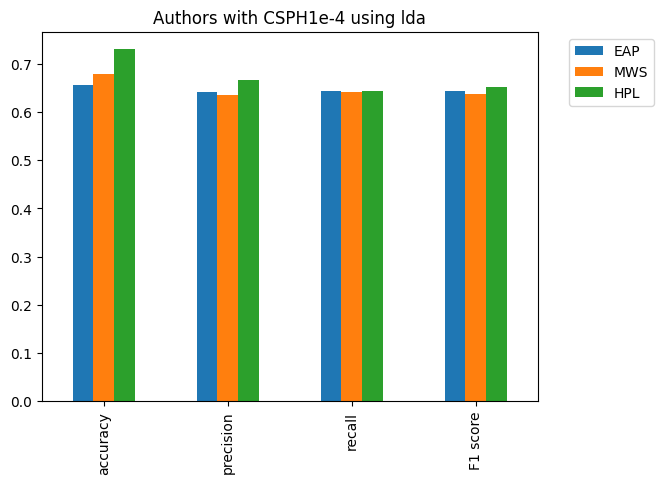

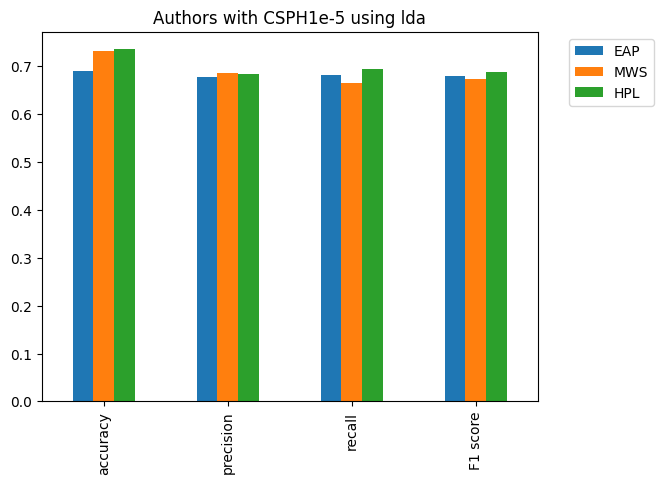

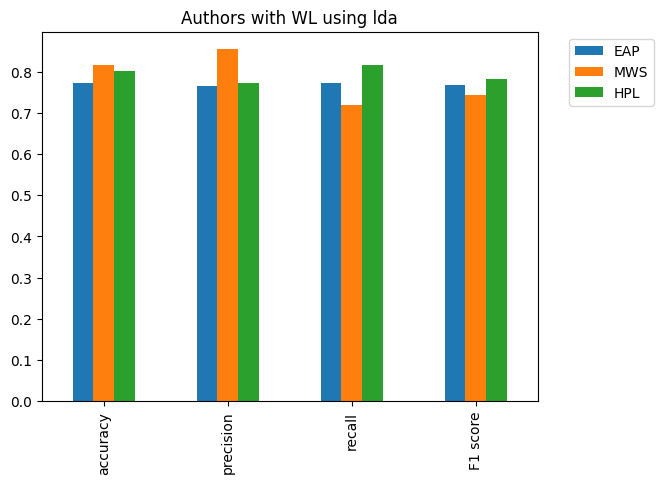

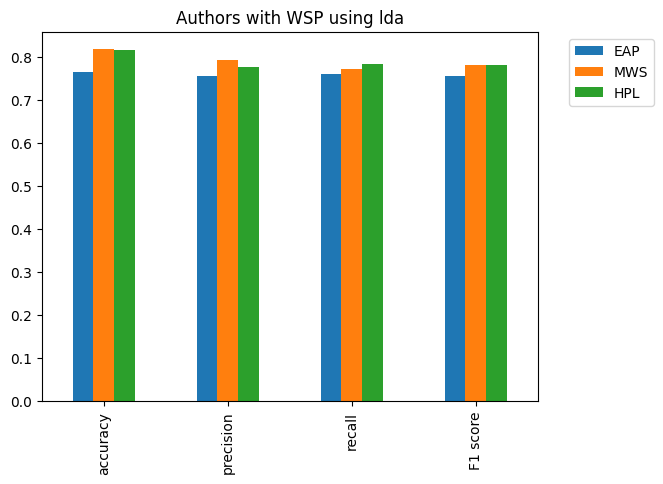

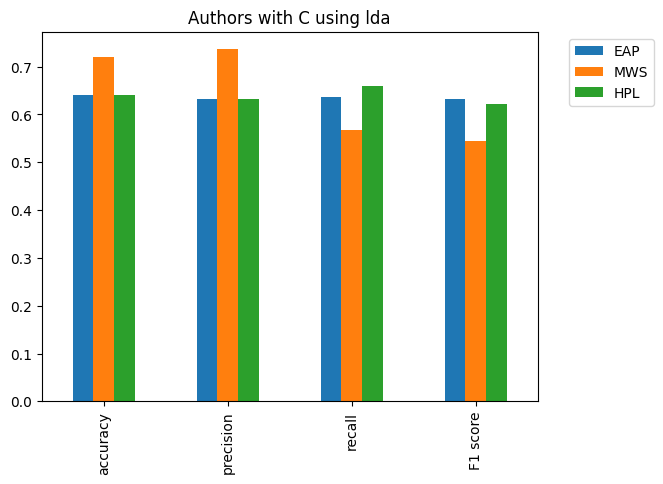

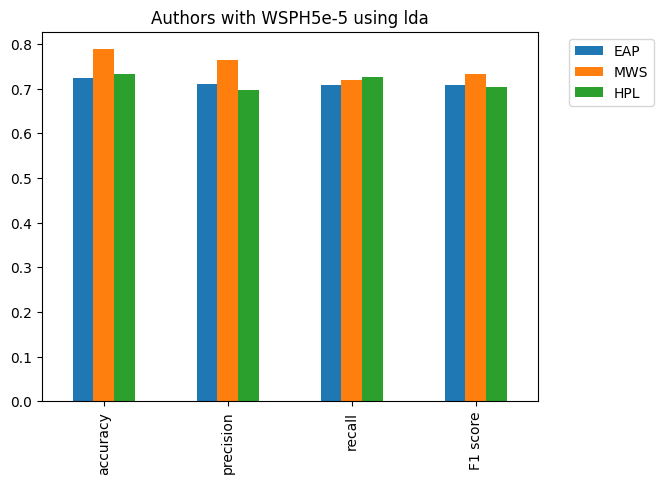

In [80]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"(author|{method})")]
    for preprocessing in range(2,int((len(method_df.columns)))):
        preprocess_name = re.sub(r".*\s(\S+)$", r"\1", method_df.columns[preprocessing])
        score_df = {}
        for author in ["EAP", "MWS", "HPL"]:
            author_df = pd.DataFrame(
                {"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                lambda x: [1 if author == i else 0 for i in x])], axis=1)
            author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
            score_df[author] = [func(author_df["author_short"],author_df.iloc[:, preprocessing]) for (name, func) in metrics]
        score_df = pd.DataFrame(score_df)
        score_df.index = ["accuracy", "precision", "recall", "F1 score"]
        score_df.plot.bar(title=f"Authors with {preprocess_name} using {method}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        

In [81]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})")]
    for preprocessing in range(2,int((len(method_df.columns)))):
        preprocess_name = re.sub(r".*\s(\S+)$", r"\1", method_df.columns[preprocessing])
        display(method_df.groupby(["author_short", method_df.columns[preprocessing]]).size().unstack(fill_value=0))

bayes with W,EAP,HPL,MWS
author_short,,,
EAP,1295,88,160
HPL,127,952,66
MWS,123,56,1049


bayes with CSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,1068,219,256
HPL,321,630,194
MWS,332,172,724


bayes with WSP,EAP,HPL,MWS
author_short,,,
EAP,1349,74,120
HPL,150,931,64
MWS,138,48,1042


bayes with CSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,1063,209,271
HPL,243,733,169
MWS,270,149,809


bayes with C,EAP,HPL,MWS
author_short,,,
EAP,1048,243,252
HPL,261,700,184
MWS,321,158,749


bayes with WSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with WSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1349,74,120
HPL,150,931,64
MWS,138,48,1042


bayes with CSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,1067,234,242
HPL,296,677,172
MWS,314,152,762


bayes with CSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1053,203,287
HPL,230,736,179
MWS,257,137,834


bayes with WSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,1316,83,144
HPL,608,406,131
MWS,588,89,551


bayes with CSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,1068,201,274
HPL,490,425,230
MWS,485,186,557


bayes with CSP,EAP,HPL,MWS
author_short,,,
EAP,1053,203,287
HPL,230,736,179
MWS,257,137,834


bayes with WSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,1336,87,120
HPL,192,884,69
MWS,175,64,989


bayes with WSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,1305,105,133
HPL,272,788,85
MWS,249,75,904


bayes with WL,EAP,HPL,MWS
author_short,,,
EAP,1295,88,160
HPL,127,952,66
MWS,123,56,1049


bayes with WPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,1278,114,151
HPL,332,712,101
MWS,316,95,817


lda with WSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,980,220,343
HPL,323,560,262
MWS,311,191,726


lda with CSP,EAP,HPL,MWS
author_short,,,
EAP,1098,312,133
HPL,347,703,95
MWS,510,281,437


lda with CSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1065,385,93
HPL,320,758,67
MWS,509,361,358


lda with W,EAP,HPL,MWS
author_short,,,
EAP,1239,262,42
HPL,196,927,22
MWS,383,225,620


lda with WSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1128,282,133
HPL,168,911,66
MWS,229,256,743


lda with CSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,981,343,219
HPL,480,486,179
MWS,529,316,383


lda with WSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,867,366,310
HPL,471,400,274
MWS,411,297,520


lda with CSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,913,336,294
HPL,300,621,224
MWS,338,254,636


lda with WSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,974,335,234
HPL,160,854,131
MWS,244,272,712


lda with CSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,912,215,416
HPL,358,499,288
MWS,360,197,671


lda with CSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,987,301,255
HPL,299,679,167
MWS,358,270,600


lda with WL,EAP,HPL,MWS
author_short,,,
EAP,1189,313,41
HPL,159,971,15
MWS,376,290,562


lda with WSP,EAP,HPL,MWS
author_short,,,
EAP,1131,217,195
HPL,247,805,93
MWS,264,166,798


lda with C,EAP,HPL,MWS
author_short,,,
EAP,956,554,33
HPL,305,810,30
MWS,515,519,194


lda with WSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,974,415,154
HPL,232,808,105
MWS,281,290,657


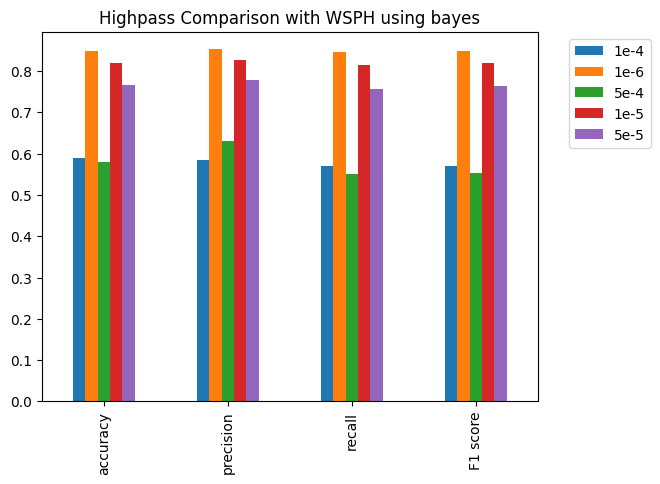

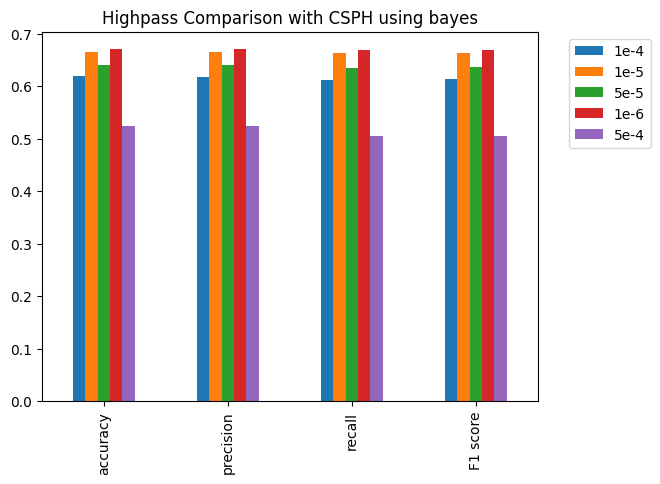

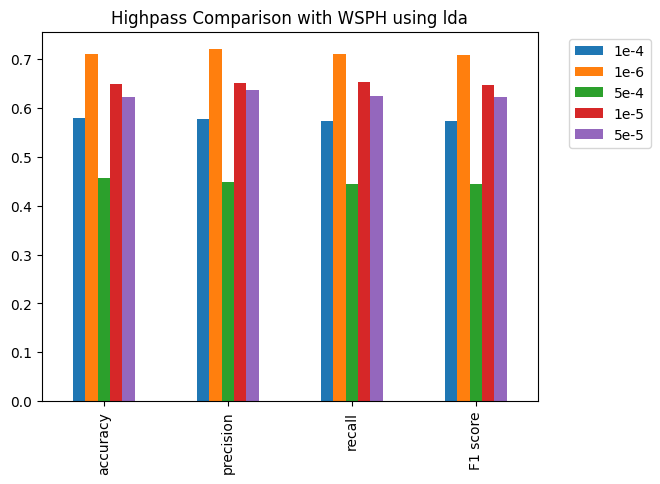

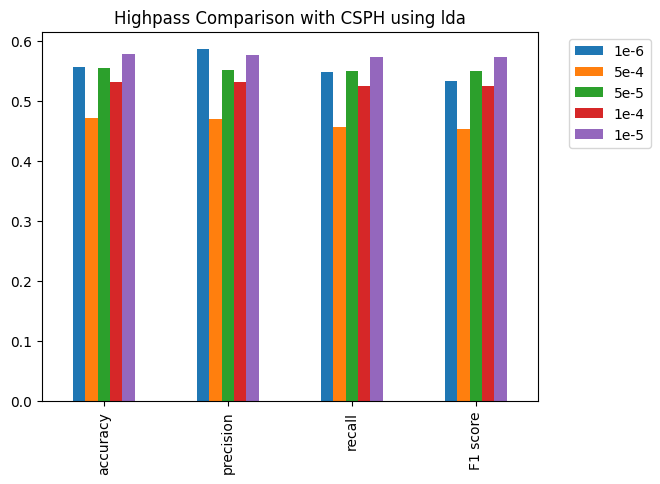

In [82]:
for method in ["bayes", "lda"]:
    for preprocessing in ["WSPH", "CSPH"]:
        method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})(?=.*{preprocessing})")]
        method_df = method_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
        score_df = method_df.iloc[: , 2:].apply(lambda x: [accuracy_score(x, method_df["author_short"]), precision_score(method_df["author_short"], x, average="macro"), recall_score(method_df["author_short"], x, average="macro"), f1_score(method_df["author_short"], x, average="macro")])
        score_df.index = ["accuracy", "precision", "recall", "F1 score"]
        score_df = score_df.rename(columns=lambda x: re.sub(r'^\D*(\d.*)', r'\1', x))
        score_df.plot.bar(title=f"Highpass Comparison with {preprocessing} using {method}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

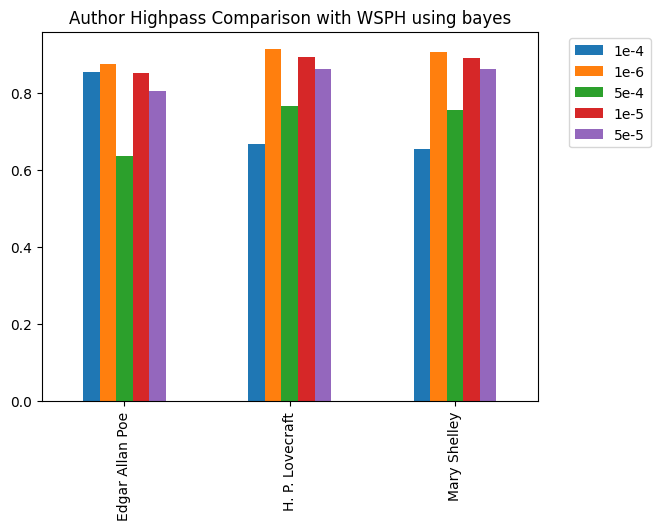

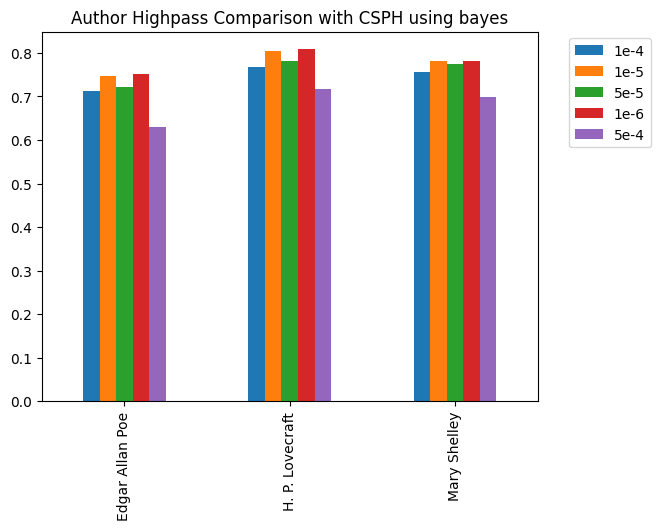

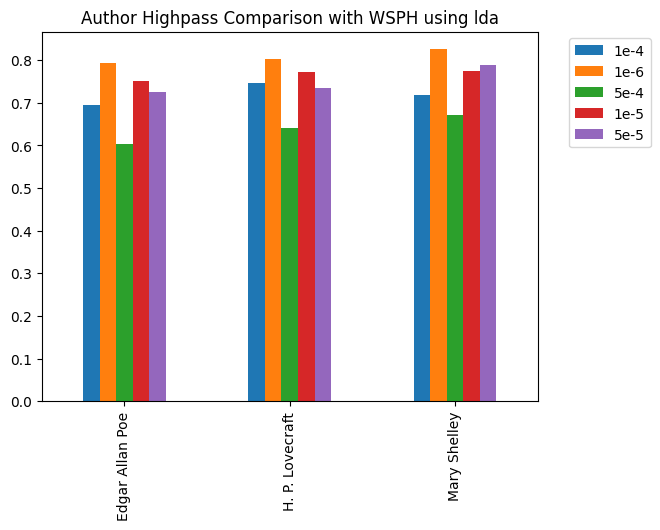

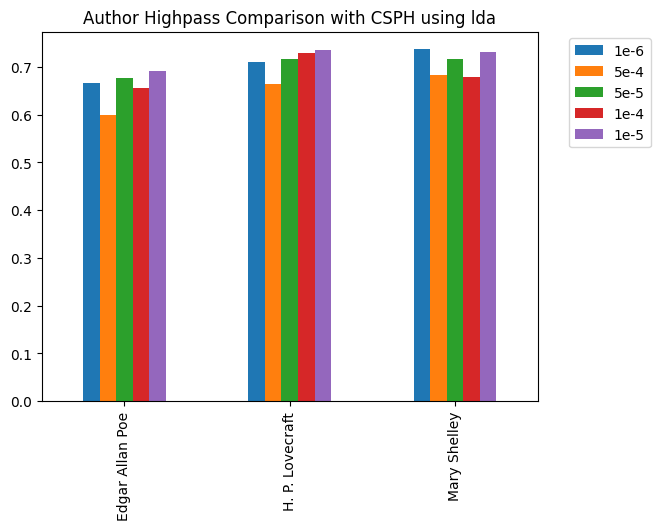

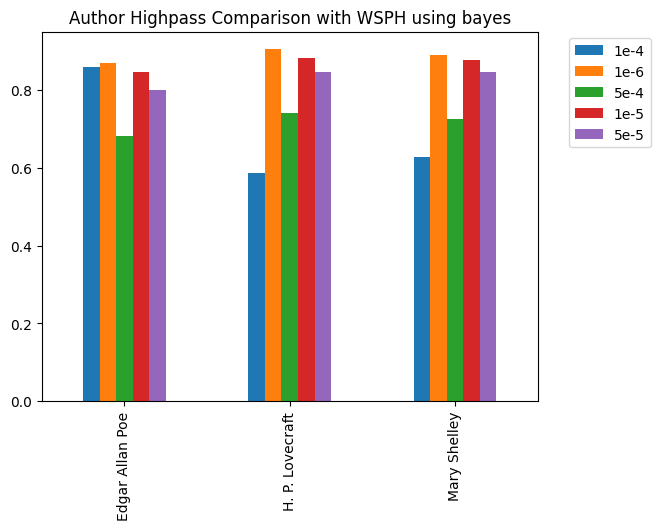

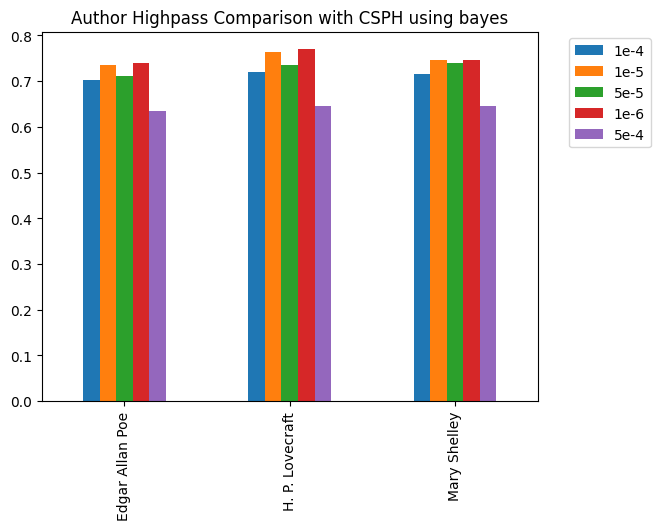

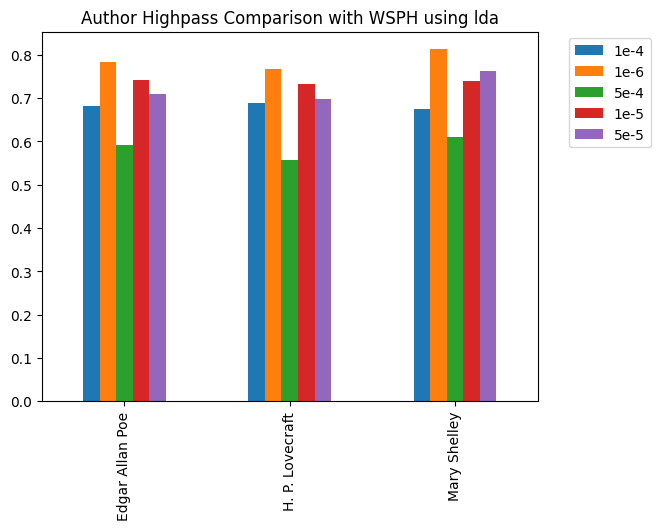

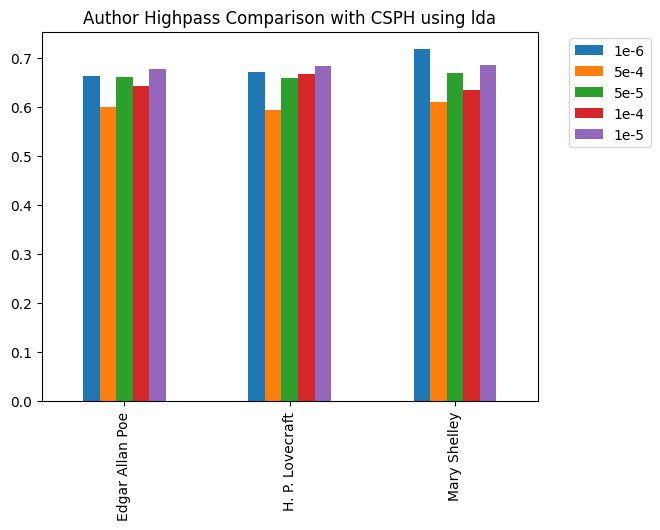

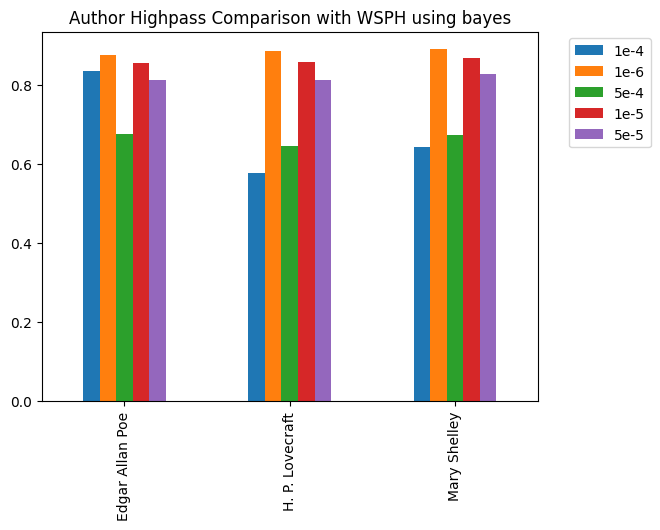

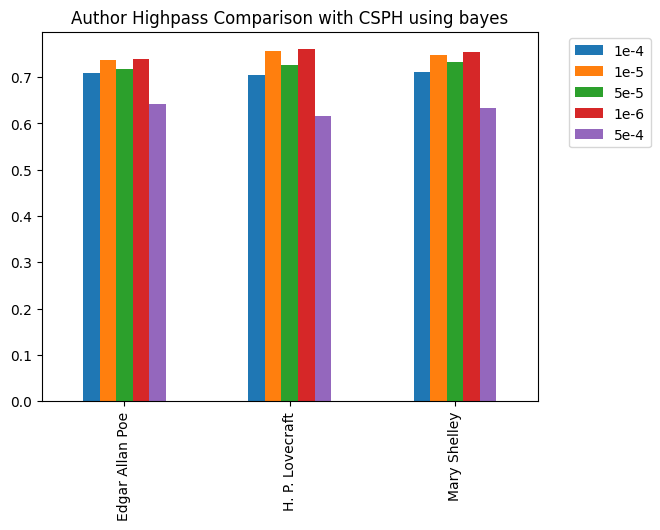

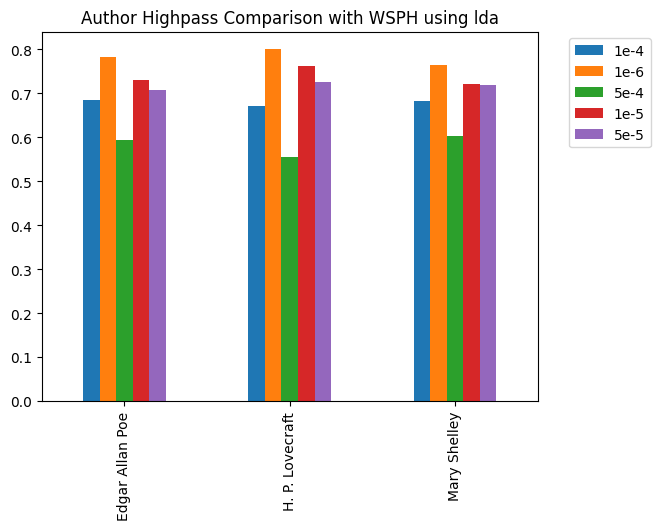

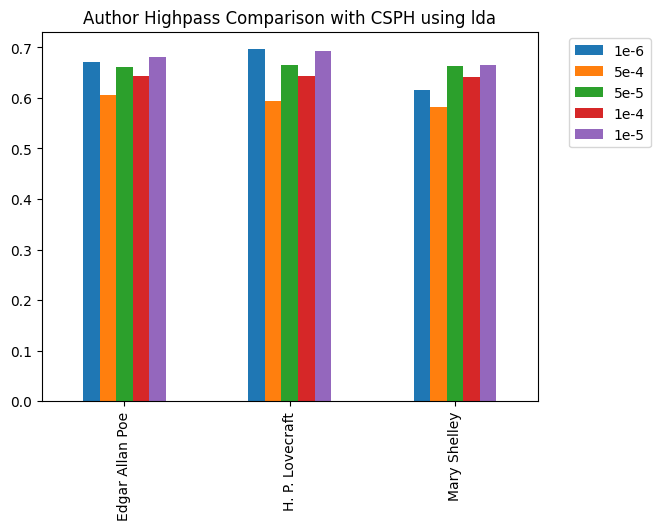

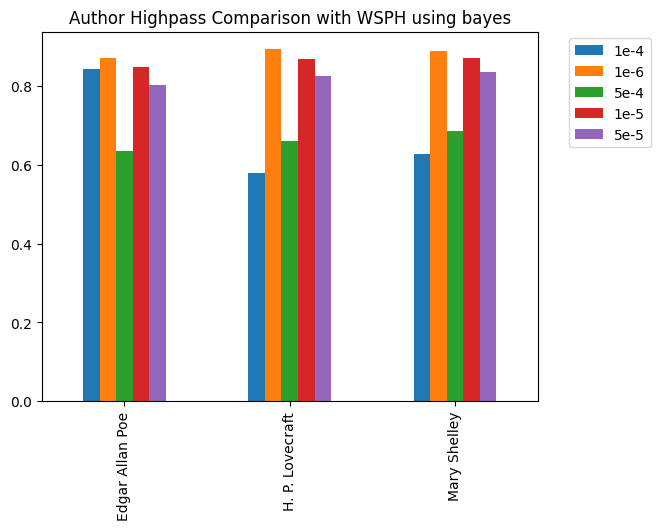

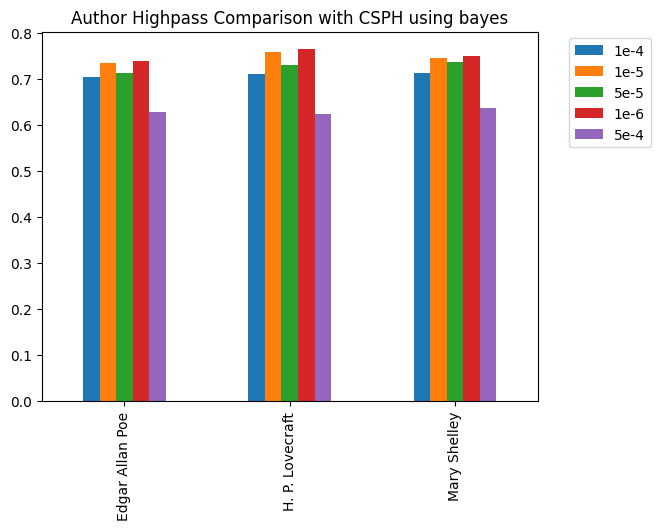

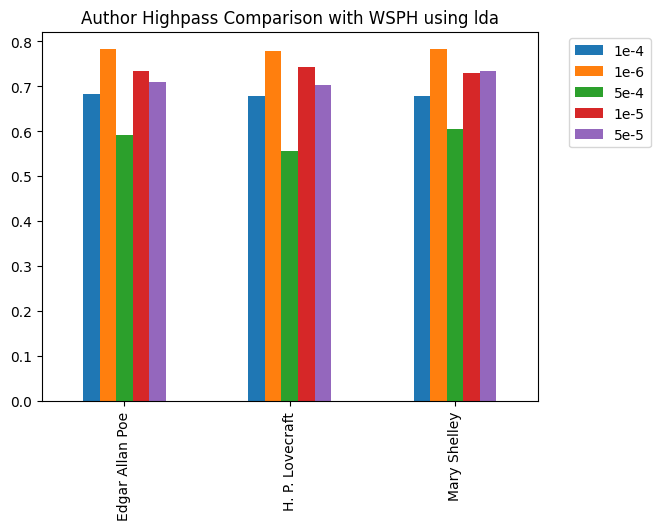

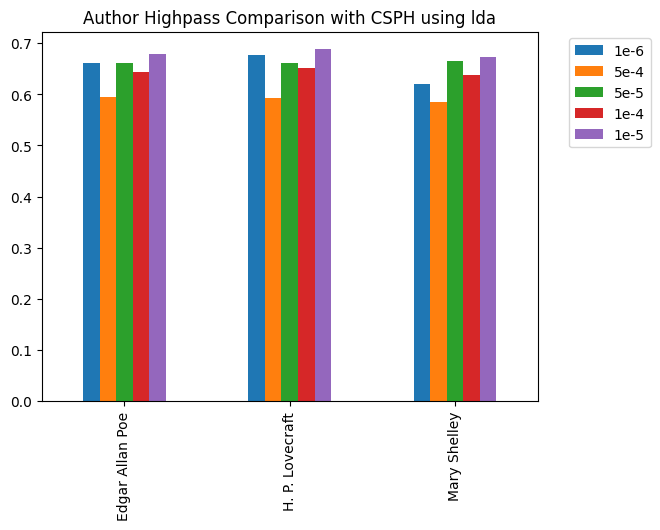

In [83]:
for (name, func) in metrics:
    for method in ["bayes", "lda"]:
        for preprocessing in ["WSPH", "CSPH"]:
            method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})(?=.*{preprocessing})")]
            cutoffs = defaultdict(lambda: [])
            for author in ["EAP", "HPL", "MWS"]:
                author_df = pd.DataFrame(
                    {"author": method_df["author"]})
                author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                    lambda x: [1 if author == i else 0 for i in x])], axis=1)
                for cutoff in range(2,int(len(author_df.columns))):
                    cutoffs[author_df.columns[cutoff]].append(func(author_df["author_short"], author_df.iloc[:, cutoff]))
            cutoffs = pd.DataFrame(cutoffs)
            cutoffs.index = [authors_short_dict[author] for author in ["EAP", "HPL", "MWS"]]
            cutoffs = cutoffs.rename(columns=lambda x: re.sub(r'^\D*(\d.*)', r'\1', x))
            cutoffs.plot.bar(title=f"Author Highpass Comparison with {preprocessing} using {method}")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
